<font size="10"><b>MINC 2500 CNN Code</b></font>

This is the code for my Computer Science Research Project named "Modern Methods for Recognising Materials &
Textures in Context" completed as part of my Master's degree.

In this paper, we evaluate modern architectures and explore alternative training procedures for the task of material and texture recognition. We show that models created from newer CNN architectures demonstrate improved accuracy and training speed while also decreasing the need for bespoke encoding layers found in previous methods. Using newer methods, the same or better accuracy can be achieved with minimal fine-tuning and training data augmentations.

# Imports
This is a list of all the python modules used. The versions of each module installed in the conda environment are in the file named conda_environment

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import time
from joblib import Parallel, delayed
import splitfolders
from PIL import Image
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.applications import MobileNetV2
from keras.applications import MobileNetV3Large
from keras.applications import MobileNetV3Small
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import Xception
mpl.rcParams['figure.dpi'] = 300

### Test GPU present

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Name of GPU available: ", tf.config.list_physical_devices('GPU')[0].name)
print("CUDA available: ", tf.test.is_built_with_cuda())

Num GPUs Available:  1
Name of GPU available:  /physical_device:GPU:0
CUDA available:  True


# Functions

## Cleanup folder function
Deletes the folder at the input directory

In [3]:
import shutil
import stat

def on_rm_error( func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    os.unlink(path)

def cleanup_folder(local_path):
    if os.path.exists(local_path):
        counter = 0
        for _ in range(30):
            try:
                shutil.rmtree(f'{local_path}', onerror = on_rm_error)
                counter += 1
                break
            except Exception:
                counter += 1
                pass
        print(f"Deletion took {counter} tries")
    else:
        print("Directory doesn't exist")

Allows cleanup of multiple folders simultaneously. It can be a lot fast in some cases

In [4]:
def cleanup_in_parallel(directory_list):
    Parallel(n_jobs=len(directory_list),
             verbose=0  # Verbose is how many progress messages
             )(delayed(cleanup_folder)
               (directory)
               for directory in
               directory_list)

Creates a new folder with the given name

In [5]:
def make_folder(directory, verbose=0):
    try:
        os.mkdir(f'{directory}')
        os.chmod(f'{directory}', 0o666)
        if verbose:
            print(f"Make directory success")
    except OSError as error:
        if verbose:
            print(f"Make directory failed: {error}")
        pass

## Image Preparation functions
In this section we cover all the functions used to resize, re-organise and modify the images from the MINC-2500 dataset

### Make second altered dataset (unused)
This was used to make another reduced class list without certain categories

In [6]:
def make_reduced_class_list(class_names, classes_to_remove, classes_to_include):
    number_of_classes = len(class_names)
    try:
        assert number_of_classes - len(classes_to_remove) >= classes_to_include
    except AssertionError:
        print("Number of classes after removal is less than minimum!")

    class_names_subset = class_names.copy()
    for class_name in classes_to_remove:
        class_names_subset.remove(class_name)

    return class_names_subset

### Resize training images
Here we define functions for resizing images.

#### Function for each set type:
This prepares the images in the categories specified and saves them to a new location

In [7]:
def prepare_set(classes_set: np.ndarray, source, destination, im_size=(224, 224)):

    for category in classes_set:
        make_folder(f'{destination}/{category}')

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'
            file_path_modified = f'{destination}/{category}/{image_name}'

            img = Image.open(file_path)
            img = img.resize(im_size)

            try:
                img = img.convert('RGB')
                img.save(file_path_modified)
                pass
            except Exception:
                pass

#### Function for parallel processing
This prepares images in parallel by splitting the category processing between all available threads

In [8]:
def parallel_prepare(classes, input_dir, output_dir, im_size, max_threads=16):
    cleanup_folder(output_dir)
    classes = np.array(classes)
    num_classes = classes.size

    make_folder(output_dir)

    if max_threads < num_classes:
        no_threads = max_threads
        classes_per_thread = num_classes // max_threads
        split_indices = np.arange(classes_per_thread, num_classes - classes_per_thread, classes_per_thread)
        split_classes = np.split(classes, split_indices)
    else:
        split_indices = np.arange(1, num_classes)
        split_classes = np.split(classes, split_indices)
        no_threads = num_classes

    start_time = time.time()
    Parallel(n_jobs=no_threads,
             verbose=0  # Verbose is how many progress messages
             )(delayed(prepare_set)
               (classes_set, input_dir, output_dir, im_size=im_size)
               for classes_set in
               split_classes)
    duration = time.time() - start_time

    print(f'{duration}s taken for resizing, cropping and padding the dataset')

### Apply image augments (unused)
In this section there is code for applying augmentations

#### Create the circular pattern for other functions
Creates a circular pattern which will be used as a mask to apply the image augmentations to the outside of the image in a circular pattern

In [9]:
import math
def create_circular_pattern(img_w_h, focused_size, blur_multiplyer=1.5):
    # Assumes square images

    try:
        assert (img_w_h-focused_size)%2 == 0
        assert focused_size > 1
    except:
        print("Ensure img_w_h and focused_size are either (odd|odd) or (even|even) not a mix. focused_size must be > 1")

    m = (img_w_h-1)/2.
    x = np.arange(img_w_h) - m
    y = np.arange(img_w_h) - m

    X, Y = np.meshgrid(x, y)
    blur_pattern = np.sqrt(X**2 + Y**2)

    if focused_size%2 == 1:
        blur_pattern -= (focused_size-1)/2.
    else:
        blur_pattern -= math.sqrt((0.5 + focused_size/2 - 1)**2 + 0.25)

    blur_pattern[blur_pattern<0] = 0
    blur_pattern /= blur_pattern.max()
    blur_pattern *= blur_multiplyer
    blur_pattern[blur_pattern>1] = 1
    blur_pattern /= blur_pattern.max()

    blur_pattern = np.repeat(blur_pattern[:, :, np.newaxis], 3, axis=2)
    return blur_pattern

This performs the augmentations in parallel on multiple threads just like the resizing

In [10]:
def parallel_prepare_augment(classes, input_dir, output_dir, blur_ratio, augmentation, max_threads=16):

    cleanup_folder(output_dir)
    classes = np.array(classes)
    num_classes = classes.size

    make_folder(output_dir)

    if max_threads < num_classes:
        no_threads = max_threads
        classes_per_thread = num_classes // max_threads
        split_indices = np.arange(classes_per_thread, num_classes - classes_per_thread, classes_per_thread)
        split_classes = np.split(classes, split_indices)
    else:
        split_indices = np.arange(1, num_classes)
        split_classes = np.split(classes, split_indices)
        no_threads = num_classes

    start_time = time.time()
    Parallel(n_jobs=no_threads,
             verbose=0  # Verbose is how many progress messages
             )(delayed(augmentation)
               (classes_set, input_dir, output_dir, blur_ratio)
               for classes_set in
               split_classes)
    duration = time.time() - start_time

    print(f'{duration}s taken for augmenting the dataset')

#### Blur function
This applies a circular blur to a set of images

In [11]:
def blur_set(classes_set: np.ndarray, source, destination, blur_ratio):

    for category in classes_set:

        make_folder(f'{destination}/{category}')

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'
            file_path_modified = f'{destination}/{category}/{image_name}'

            img = Image.open(file_path)
            img_blur = cv2.GaussianBlur(np.array(img), ksize=(11,11), sigmaX=10.0)
            img_part = np.uint8((blur_ratio * img_blur) + ((1 - blur_ratio) * img))

            # print(file_path_modified)
            try:
                # img_part = img_part.convert('RGB')
                img_part_conv = Image.fromarray(img_part)
                img_part_conv.save(file_path_modified)
                pass
            except Exception as error:
                print(error)
                pass

#### Vignette
This applies a circular vignette to the images

In [12]:
def vignette_set(classes_set: np.ndarray, source, destination, blur_ratio):

    for category in classes_set:
        make_folder(f'{destination}/{category}')

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'
            file_path_modified = f'{destination}/{category}/{image_name}'

            img = Image.open(file_path)
            img = np.array(img)
            img_black = np.zeros_like(img)

            img_part = np.uint8((blur_ratio * img_black) + ((1 - blur_ratio) * img))

            # print(file_path_modified)
            try:
                # img_part = img_part.convert('RGB')
                img_part_conv = Image.fromarray(img_part)
                img_part_conv.save(file_path_modified)
                pass
            except Exception as error:
                print(error)
                pass

#### Greyscale
This applies the circular pattern with a greyscale image and the original resulting in an image with the circular edges being in greyscale

In [13]:
def greyscale_set(classes_set: np.ndarray, source, destination, blur_ratio):

    for category in classes_set:
        make_folder(f'{destination}/{category}')

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'
            file_path_modified = f'{destination}/{category}/{image_name}'

            img = Image.open(file_path)
            img = np.array(img)

            img_grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img_grey = cv2.cvtColor(img_grey,cv2.COLOR_GRAY2RGB)

            img_part = np.uint8((blur_ratio * img_grey) + ((1 - blur_ratio) * img))

            # print(file_path_modified)
            try:
                # img_part = img_part.convert('RGB')
                img_part_conv = Image.fromarray(img_part)
                img_part_conv.save(file_path_modified)
                pass
            except Exception as error:
                print(error)
                pass

#### Greyscale and Blur
This applies the circular pattern with a greyscale-blurred image and the original resulting in an image with the circular edges being in greyscale and blurred

In [14]:
def greyscale_blur_set(classes_set: np.ndarray, source, destination, blur_ratio):

    for category in classes_set:
        make_folder(f'{destination}/{category}')

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'
            file_path_modified = f'{destination}/{category}/{image_name}'

            img = Image.open(file_path)
            img = np.array(img)

            img_grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img_grey = cv2.cvtColor(img_grey,cv2.COLOR_GRAY2RGB)
            img_blur = cv2.GaussianBlur(np.array(img_grey), ksize=(11,11), sigmaX=10.0)

            img_part = np.uint8((blur_ratio * img_blur) + ((1 - blur_ratio) * img))

            # print(file_path_modified)
            try:
                # img_part = img_part.convert('RGB')
                img_part_conv = Image.fromarray(img_part)
                img_part_conv.save(file_path_modified)
                pass
            except Exception as error:
                print(error)
                pass

### Split folders
These functions split the folders into the train, test and validation sets

In [15]:
def split_folder(in_dir):
    splitfolders.ratio(in_dir, output=in_dir+"_split", seed=445, ratio=(.8, 0.1, 0.1))

In [16]:
def split_in_parallel(directory_list):
    Parallel(n_jobs=len(directory_list),
             verbose=0  # Verbose is how many progress messages
             )(delayed(split_folder)
               (directory)
               for directory in
               directory_list)

### Import the dataset function
This imports the datasets from the split folders

In [17]:
def import_datasets(batch_size, directory, im_size, prefetch=True):
    train_ds = keras.utils.image_dataset_from_directory(
        directory=f'{directory}/train/',
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        seed=445,
        image_size=im_size)
    validation_ds = keras.utils.image_dataset_from_directory(
        directory=f'{directory}/val/',
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        image_size=im_size)
    test_ds = keras.utils.image_dataset_from_directory(
        directory=f'{directory}/test/',
        labels='inferred',
        label_mode='categorical',
        shuffle=False,
        image_size=im_size)
    if prefetch:
        train_ds = train_ds.prefetch(buffer_size=batch_size)
        validation_ds = validation_ds.prefetch(buffer_size=batch_size)
    return train_ds, validation_ds, test_ds

## Define the models
These two functions create a model from the input model architecture using standard settings. One of them includes the top layer while the other creates it from scratch. The second version is designed to allow loading of pre-trained weights.

In [18]:
def create_model(number_of_classes, model_type, weights=None):
    new_model = model_type(
        include_top=True,
        weights=weights,
        input_tensor=None,
        input_shape=None,
        pooling='avg',
        classes=number_of_classes)
    return new_model

In [ ]:
def create_no_top_model(number_of_classes, model_type, weights=None):
    new_model = model_type(
        include_top=False,
        weights=weights,
        input_tensor=None,
        input_shape=None,
        pooling='avg',
        classes=number_of_classes)
    complete_model = Sequential()
    complete_model.add(new_model)
    complete_model.add(Dense(number_of_classes, activation="softmax"))
    return complete_model

In [ ]:
def create_flip_model(number_of_classes, model_type, weights=None, image_size=(224, 224)):
    new_model = model_type(
        include_top=False,
        weights=weights,
        input_tensor=None,
        input_shape=None,
        pooling='avg',
        classes=number_of_classes)
    complete_model = Sequential()
    # complete_model.add(layers.res("horizontal_and_vertical"))
    complete_model.add(layers.RandomFlip("horizontal_and_vertical"))
    complete_model.add(layers.RandomRotation(0.2))
    complete_model.add(new_model)
    complete_model.add(Dense(number_of_classes, activation="softmax"))
    complete_model.build((None,) + image_size + (3,))
    return complete_model

## Training functions
This compiles the model and gets it ready for training

In [19]:
def compile_model(parent_directory, model, model_name, loss='categorical_crossentropy', optimizer='SGD'):
    callbacks = [
        keras.callbacks.ModelCheckpoint(parent_directory + "minc-training/"+ model_name + "_{epoch}.h5",
                                        # save_best_only=True
                                        ),
        # keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
    ]
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
    )
    return model, model_name, callbacks

## Evaluation
Here are a selection of functions used to benchmark and test each model. Some don't produce graphs or info that are present in the report but were still used to guide experimentation

This tests the accuracy of the CNN in each category. It loads each individual image at a time

In [20]:
# This loads the best CNN model
def test_cnn(model_name, checkpoint_number, prefix_directory, image_size, classes, verbose=0, set_name='val'):
    cnn_model = tf.keras.models.load_model(f'{prefix_directory}/{model_name}_{checkpoint_number}.h5')
    # cnn_accuracy_sets = []
    cnn_accuracy_per_class = []

    for category in classes:
        if verbose == 1:
            print(f"Testing {set_name}:{category}")

        wrong = 0
        count = 0
        for image_name in os.listdir(f'{data_split}/{set_name}/{category}'):
            path = f'{data_split}/{set_name}/{category}/{image_name}'
            img = keras.preprocessing.image.load_img(path, target_size=image_size)

            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create batch axis

            probs = cnn_model.predict(img_array, verbose=0)
            predictions = np.argmax(probs)

            if verbose == 3:
                print(category, classes[predictions])

            if category != classes[predictions]:
                if verbose == 2:
                    print(category, classes[predictions])
                wrong += 1
            count += 1

        cnn_accuracy_per_class.append(1 - (wrong/count))
    return cnn_accuracy_per_class

This loads all the images at once and is a much faster version of the function above

In [21]:
# This loads the best CNN model
def test_cnn_quick(model_name, checkpoint_number, prefix_directory, image_size, classes, set, verbose=0):
    cnn_model = tf.keras.models.load_model(f'{prefix_directory}/{model_name}_{checkpoint_number}.h5')
    cnn_accuracy_per_class = np.zeros(len(classes))
    probs = cnn_model.predict(set, verbose=0)
    labels = np.argmax(np.concatenate([y for x, y in set], axis=0), axis=1)
    preds = np.argmax(probs, axis=1)
    correct = labels == preds

    for idx, category in enumerate(classes):
        category_indices = np.where(labels == idx)
        cnn_accuracy_per_class[idx] = np.count_nonzero(correct[category_indices])/correct[category_indices].size

    percentage = np.count_nonzero(correct)/correct.size
    print(percentage)
    return cnn_accuracy_per_class

In [23]:
def print_class_accuracy(class_accuracy, classes):
    for idx, class_name in enumerate(classes):
        print(f"{class_name:14}:\t{class_accuracy[idx]*100:.1f}%")

These two functions evaluate the models on the 3 sets and prints the results

In [22]:
def evaluate_cnn(model_name, checkpoint_number, prefix_directory, image_size, datasets):
    cnn_model = tf.keras.models.load_model(f'{prefix_directory}minc-training/{model_name}_{checkpoint_number}.h5')
    cnn_evaluations = [cnn_model.evaluate(datasets['train'], verbose=0)[1],
                     cnn_model.evaluate(datasets['validation'], verbose=0)[1],
                     cnn_model.evaluate(datasets['test'], verbose=0)[1]]
    return cnn_evaluations

In [24]:
def print_evaluation(accuracy_set):
    print(f"Train     \t:\t{accuracy_set[0]*100:.1f}%")
    print(f"Validation\t:\t{accuracy_set[1]*100:.1f}%")
    print(f"Test      \t:\t{accuracy_set[2]*100:.1f}%")

This tests the input model and produces a confusion matrix

In [146]:
def graph_confusion_matrix(model_name, checkpoint_number, prefix_directory, image_size, classes, set, verbose=0, colour_palette="Blues"):
    cnn_model = tf.keras.models.load_model(f'{prefix_directory}/{model_name}_{checkpoint_number}.h5')
    probs = cnn_model.predict(set, verbose=0)
    labels = np.argmax(np.concatenate([y for x, y in set], axis=0), axis=1)
    preds = np.argmax(probs, axis=1)
    num_classes = len(classes)
    conf = np.array(tf.math.confusion_matrix(labels, preds, num_classes=num_classes))/(labels.size/num_classes)
    g = sb.heatmap(conf, cmap=sb.color_palette(colour_palette, as_cmap=True), vmin=0, vmax=1, xticklabels=classes, yticklabels=classes, cbar=False)
    g.xaxis.set_ticks_position("top")
    plt.xticks(rotation=90)
    return conf

These two function are used to extract training, validation and testing accuracies from every epoch for a certain model. This was used extensively for the graphs in the report

In [134]:
def evaluate_epoch(model, datasets, verbose=0):
    evaluation = (model.evaluate(datasets[0], verbose=verbose)[1],
                  model.evaluate(datasets[1], verbose=0)[1],
                  model.evaluate(datasets[2], verbose=0)[1])
    return evaluation

In [135]:
def test_every_epoch(model: Sequential, model_name, prefix_directory, datasets):
    training, validating, testing = [], [], []
    for i in range(100):
        if os.path.exists(f'{prefix_directory}minc-training/{model_name}_{i+1}.h5'):
            model.load_weights(f"{parent_directory}minc-training/{model_name}_{i+1}.h5")
            evaluation = evaluate_epoch(model, datasets, verbose=1)
            training.append(evaluation[0])
            validating.append(evaluation[1])
            testing.append(evaluation[2])
        else:
            print(f"Ending at epoch {i+1}!")
            break
    return training, validating, testing

##### RUN ALL ABOVE BEFORE STARTING

# Define the dataset
Here we define some things about the dataset

## Define set
The file directories of where the dataset is loacted has been provided

In [26]:
parent_directory = "C:/MLDatasets/"
data_source = 'C:/MLDatasets/minc-2500/images'
data_resized = 'C:/MLDatasets/minc-2500/images_resized'
data_split = 'C:/MLDatasets/minc-2500/images_split'
class_names = list(os.listdir(f'{data_source}'))
no_classes = len(class_names)
print(class_names)
image_size_orig = (362, 362)
image_size = (224, 224)

['brick', 'carpet', 'ceramic', 'fabric', 'foliage', 'food', 'glass', 'hair', 'leather', 'metal', 'mirror', 'other', 'painted', 'paper', 'plastic', 'polishedstone', 'skin', 'sky', 'stone', 'tile', 'wallpaper', 'water', 'wood']


These two cells resize and split the MINC-2500 dataset

In [90]:
cleanup_folder(data_resized)
parallel_prepare(class_names, data_source, data_resized, image_size)

Directory doesn't exist
Make directory success


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  22 | elapsed:   30.1s remaining:  3.2min
[Parallel(n_jobs=16)]: Done   9 out of  22 | elapsed:   31.4s remaining:   45.4s
[Parallel(n_jobs=16)]: Done  15 out of  22 | elapsed:   32.1s remaining:   14.9s


62.83606147766113s taken for resizing, cropping and padding the dataset


[Parallel(n_jobs=16)]: Done  22 out of  22 | elapsed:  1.0min finished


In [91]:
cleanup_folder(data_split)
splitfolders.ratio(data_resized, output=f'{data_split}', seed=445, ratio=(.8, 0.1, 0.1))

Directory doesn't exist


## Define Subset
This is a repeat of the functions above but for a subset of the dataset (Unused)

In [ ]:
classes_excluded = ['fabric', "ceramic", "glass", "metal", "other", "paper", "plastic", "stone", "tile", "wallpaper"]
class_names_subset = make_reduced_class_list(class_names, classes_excluded, 13)
print(class_names_subset)
no_classes_subset = len(class_names_subset)
print(no_classes_subset)

In [26]:
data_resized_reduced = f'{data_resized}_reduced'
data_split_reduced = f'{data_split}_reduced'

In [ ]:
cleanup_folder(data_resized_reduced)
parallel_prepare(class_names_subset, data_source, data_resized_reduced, image_size)

cleanup_folder(data_split_reduced)
splitfolders.ratio(data_resized_reduced, output=data_split_reduced, seed=445, ratio=(.8, 0.1, 0.1))

# Create 299x299 dataset
Here we specify and prepare images for a second version of the full dataset but with a 299x299 resolution

In [27]:
size_299 = "_299x299"
image_size_299 = (299, 299)
data_resized_299 = data_resized+size_299
data_split_299= data_split+size_299

In [46]:
cleanup_folder(data_resized_299)
parallel_prepare(class_names, data_source, data_resized_299, image_size_299)

Directory doesn't exist
Directory doesn't exist
Make directory success
73.24393796920776s taken for resizing, cropping and padding the dataset


In [47]:
cleanup_folder(data_split_299)
splitfolders.ratio(data_resized_299, output=data_split_299, seed=445, ratio=(.8, 0.1, 0.1))

Directory doesn't exist


# Create augmented datasets (Unused)
Using the augmented datasets was not useful so it was not developed further. This section covers the creation and splitting of the augmented datasets

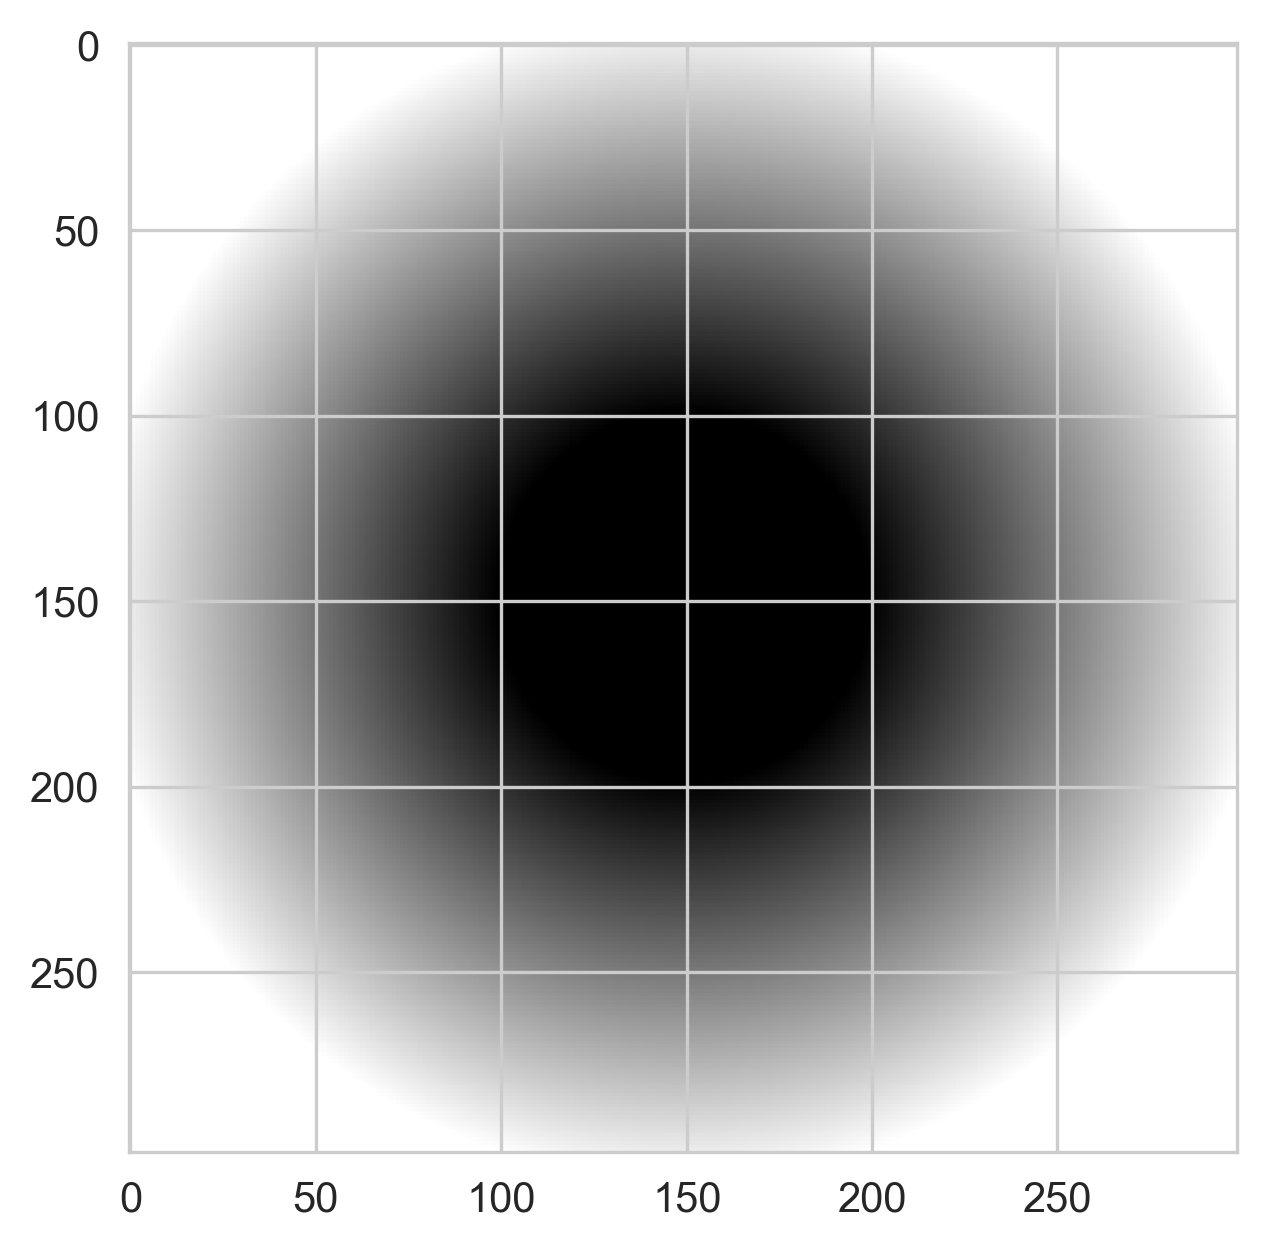

In [33]:
class_names_augmentation = class_names
# class_names_augmentation = class_names_subset

# pattern = create_circular_pattern(224, 64)
pattern = create_circular_pattern(299, 101)
plt.imshow(pattern)
plt.show()

data_blurred =          'C:/MLDatasets/minc-2500/images_blurred'
data_vignette =         'C:/MLDatasets/minc-2500/images_vignette'
data_greyscale =        'C:/MLDatasets/minc-2500/images_greyscale'
data_greyscale_blur =   'C:/MLDatasets/minc-2500/images_greyscale_blur'

In [49]:
print('\nCleaning folders...')
cleanup_folder(data_blurred)
cleanup_folder(data_vignette)
cleanup_folder(data_greyscale)
cleanup_folder(data_greyscale_blur)

print('\nBlurring...')
parallel_prepare_augment(class_names_augmentation, data_resized_299, data_blurred, pattern, blur_set)
print('\nVignetting..')
parallel_prepare_augment(class_names_augmentation, data_resized_299, data_vignette, pattern, vignette_set)
print('\nGreyscaling...')
parallel_prepare_augment(class_names_augmentation, data_resized_299, data_greyscale, pattern, greyscale_set)
print('\nBlurring and greyscaling...')
parallel_prepare_augment(class_names_augmentation, data_resized_299, data_greyscale_blur, pattern, greyscale_blur_set)


Cleaning folders...
Deletion took 1 tries
Deletion took 1 tries
Deletion took 1 tries
Deletion took 1 tries

Blurring...
Directory doesn't exist
223.43524479866028s taken for augmenting the dataset

Vignetting..
Directory doesn't exist
181.87397360801697s taken for augmenting the dataset

Greyscaling...
Directory doesn't exist
172.17775583267212s taken for augmenting the dataset

Blurring and greyscaling...
Directory doesn't exist
196.0824418067932s taken for augmenting the dataset


In [28]:
data_split_blurred = data_blurred+'_split'
data_split_vignette = data_vignette+'_split'
data_split_greyscale = data_greyscale+'_split'
data_split_greyscale_blur = data_greyscale_blur+'_split'

NameError: name 'data_blurred' is not defined

In [ ]:
cleanup_in_parallel([data_split_blurred, data_split_vignette, data_split_greyscale, data_split_greyscale_blur])

In [52]:
cleanup_folder(data_split_blurred)
cleanup_folder(data_split_vignette)
cleanup_folder(data_split_greyscale)
cleanup_folder(data_split_greyscale_blur)

Deletion took 1 tries
Deletion took 1 tries
Deletion took 1 tries
Deletion took 1 tries


In [54]:
split_in_parallel([data_blurred, data_vignette, data_greyscale, data_greyscale_blur])

In [51]:
splitfolders.ratio(data_blurred, output=data_split_blurred, seed=445, ratio=(.8, 0.1, 0.1))
splitfolders.ratio(data_vignette, output=data_split_vignette, seed=445, ratio=(.8, 0.1, 0.1))
splitfolders.ratio(data_greyscale, output=data_split_greyscale, seed=445, ratio=(.8, 0.1, 0.1))
splitfolders.ratio(data_greyscale_blur, output=data_split_greyscale_blur, seed=445, ratio=(.8, 0.1, 0.1))

KeyboardInterrupt: 

# Basic training on a selection of models
Here we train the 7 models on the MINC-2500 dataset

## Import datasets
Each dataset is uncommented and imported when needed to avoid unneccesary resource usage

In [32]:
# train_ds, validation_ds, test_ds = import_datasets(24, data_split, image_size)
train_ds_299, validation_ds_299, test_ds_299 = import_datasets(24, data_split_299, image_size_299)
# train_ds_red, validation_ds_red, test_ds_red = import_datasets(32, data_split_reduced, image_size)
# train_ds_aug, validation_ds_aug, test_ds_aug = import_datasets(32, data_split_blurred, image_size)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


## Train (224x224)
Here we define and train the models which use the 224x224 image dimension dataset

In [27]:
epochs = 100

### MobileNetV2

In [ ]:
train_ds, validation_ds, test_ds = import_datasets(32, data_split, image_size)

In [174]:
from keras.applications import MobileNetV2
MobileNetV2Model = create_model(no_classes, MobileNetV2)
MobileNetV2Model, _, callbacks = compile_model(parent_directory, MobileNetV2Model, 'MobileNetV2_base', loss='categorical_crossentropy', optimizer='SGD')

In [34]:
MobileNetV2Model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/100
1438/1438 [==============================] - 236s 150ms/step - loss: 2.6003 - accuracy: 0.2222 - val_loss: 3.2222 - val_accuracy: 0.0435
Epoch 2/100
1438/1438 [==============================] - 211s 146ms/step - loss: 2.2222 - accuracy: 0.3342 - val_loss: 3.4094 - val_accuracy: 0.0435
Epoch 3/100
1438/1438 [==============================] - 211s 146ms/step - loss: 2.0035 - accuracy: 0.3960 - val_loss: 3.7345 - val_accuracy: 0.0435
Epoch 4/100
1438/1438 [==============================] - 209s 145ms/step - loss: 1.8538 - accuracy: 0.4381 - val_loss: 3.4042 - val_accuracy: 0.0748
Epoch 5/100
1438/1438 [==============================] - 211s 147ms/step - loss: 1.7285 - accuracy: 0.4750 - val_loss: 1.9432 - val_accuracy: 0.4184
Epoch 6/100
1438/1438 [==============================] - 212s 147ms/step - loss: 1.6264 - accuracy: 0.5032 - val_loss: 2.4755 - val_accuracy: 0.3280
Epoch 7/100
1438/1438 [==============================] - 210s 146ms/step - loss: 1.5398 - accuracy: 0.5291

KeyboardInterrupt: 

In [39]:
cnn_accuracy_sets = evaluate_cnn('MobileNetV2_base', 75, parent_directory, image_size)
print(f"Train     \t:\t{cnn_accuracy_sets[0]*100:.1f}%")
print(f"Validation\t:\t{cnn_accuracy_sets[1]*100:.1f}%")
print(f"Test      \t:\t{cnn_accuracy_sets[2]*100:.1f}%")

Train     	:	99.2%
Validation	:	52.4%
Test      	:	52.8%


### MobileNetV3Large

In [175]:
train_ds, validation_ds, test_ds = import_datasets(32, data_split, image_size)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


KeyboardInterrupt: 

In [176]:
from keras.applications import MobileNetV3Large
MobileNetV3LargeModel = create_model(no_classes, MobileNetV3Large)
MobileNetV3LargeModel, _, callbacks = compile_model(parent_directory, MobileNetV3LargeModel, 'MobileNetV3Large_base', loss='categorical_crossentropy', optimizer='SGD')

In [28]:
last_train = MobileNetV3LargeModel.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/100
1438/1438 [==============================] - 225s 146ms/step - loss: 2.5439 - accuracy: 0.2447 - val_loss: 3.1454 - val_accuracy: 0.0435
Epoch 2/100
1438/1438 [==============================] - 206s 143ms/step - loss: 2.1249 - accuracy: 0.3624 - val_loss: 3.1919 - val_accuracy: 0.0435
Epoch 3/100
1438/1438 [==============================] - 206s 143ms/step - loss: 1.9322 - accuracy: 0.4149 - val_loss: 3.2946 - val_accuracy: 0.0435
Epoch 4/100
1438/1438 [==============================] - 206s 143ms/step - loss: 1.7925 - accuracy: 0.4541 - val_loss: 2.7500 - val_accuracy: 0.1856
Epoch 5/100
1438/1438 [==============================] - 206s 143ms/step - loss: 1.6776 - accuracy: 0.4882 - val_loss: 1.8663 - val_accuracy: 0.4362
Epoch 6/100
1438/1438 [==============================] - 206s 143ms/step - loss: 1.5776 - accuracy: 0.5170 - val_loss: 1.9073 - val_accuracy: 0.4332
Epoch 7/100
1438/1438 [==============================] - 206s 143ms/step - loss: 1.4944 - accuracy: 0.5399

In [ ]:
train_ds, validation_ds, test_ds = import_datasets(32, data_split, image_size)

In [177]:
from keras.applications import MobileNetV3Large
MobileNetV3LargeModel = create_model(no_classes, MobileNetV3Large)
MobileNetV3LargeModel, _, callbacks = compile_model(parent_directory, MobileNetV3LargeModel, 'MobileNetV3Large_imagenet', loss='categorical_crossentropy', optimizer='SGD')

In [ ]:
last_train = MobileNetV3LargeModel.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

### ResNet152V2

In [31]:
train_ds, validation_ds, test_ds = import_datasets(28, data_split, image_size)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [178]:
from keras.applications import ResNet152V2
ResNet152V2Model = create_model(no_classes, ResNet152V2)
ResNet152V2Model, _, callbacks = compile_model(parent_directory, ResNet152V2Model, 'ResNet152V2_base', loss='categorical_crossentropy', optimizer='SGD')

In [32]:
ResNet152V2Model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/50
1917/1917 [==============================] - 627s 326ms/step - loss: 2.7466 - accuracy: 0.1832 - val_loss: 2.6098 - val_accuracy: 0.2162
Epoch 2/50
1917/1917 [==============================] - 622s 325ms/step - loss: 2.4605 - accuracy: 0.2633 - val_loss: 3.6130 - val_accuracy: 0.1430
Epoch 3/50
1917/1917 [==============================] - 619s 323ms/step - loss: 2.2351 - accuracy: 0.3293 - val_loss: 3.3113 - val_accuracy: 0.1810
Epoch 4/50
1917/1917 [==============================] - 645s 336ms/step - loss: 2.0537 - accuracy: 0.3824 - val_loss: 2.4916 - val_accuracy: 0.2918
Epoch 5/50
1917/1917 [==============================] - 621s 324ms/step - loss: 1.9071 - accuracy: 0.4214 - val_loss: 1.9920 - val_accuracy: 0.4033
Epoch 6/50
1917/1917 [==============================] - 613s 319ms/step - loss: 1.7811 - accuracy: 0.4605 - val_loss: 2.4126 - val_accuracy: 0.3376
Epoch 7/50
1917/1917 [==============================] - 613s 320ms/step - loss: 1.6685 - accuracy: 0.4920 - val_

KeyboardInterrupt: 

In [32]:
resume_from = 50
ResNet152V2Model.load_weights(f"{parent_directory}minc-training/ResNet152V2_base_{resume_from}.h5")
ResNet152V2Model.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=validation_ds, initial_epoch=resume_from)

Epoch 46/50
1643/1643 [==============================] - 682s 395ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 2.8806 - val_accuracy: 0.5292
Epoch 47/50
1643/1643 [==============================] - 636s 387ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 2.8273 - val_accuracy: 0.5346
Epoch 48/50
1643/1643 [==============================] - 638s 388ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 2.8551 - val_accuracy: 0.5290
Epoch 49/50
1643/1643 [==============================] - 624s 380ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 2.8299 - val_accuracy: 0.5261
Epoch 50/50
1643/1643 [==============================] - 604s 367ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 2.8788 - val_accuracy: 0.5318


### VGG19

In [179]:
from keras.applications import VGG19
VGG19Model = create_model(no_classes, VGG19)
VGG19Model, _, callbacks = compile_model(parent_directory, VGG19Model, 'VGG19_base', loss='categorical_crossentropy', optimizer='SGD')

In [33]:
VGG19Model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/100
1438/1438 [==============================] - 398s 268ms/step - loss: 2.9253 - accuracy: 0.1297 - val_loss: 2.6717 - val_accuracy: 0.2318
Epoch 2/100
1438/1438 [==============================] - 384s 267ms/step - loss: 2.5232 - accuracy: 0.2553 - val_loss: 2.4972 - val_accuracy: 0.2744
Epoch 3/100
1438/1438 [==============================] - 384s 267ms/step - loss: 2.1860 - accuracy: 0.3520 - val_loss: 2.2195 - val_accuracy: 0.3370
Epoch 4/100
1438/1438 [==============================] - 385s 268ms/step - loss: 1.9720 - accuracy: 0.4148 - val_loss: 2.2615 - val_accuracy: 0.3252
Epoch 5/100
1438/1438 [==============================] - 386s 268ms/step - loss: 1.7642 - accuracy: 0.4684 - val_loss: 2.0702 - val_accuracy: 0.4012
Epoch 6/100
1438/1438 [==============================] - 385s 267ms/step - loss: 1.5240 - accuracy: 0.5355 - val_loss: 2.2797 - val_accuracy: 0.3605
Epoch 7/100
1438/1438 [==============================] - 384s 267ms/step - loss: 1.2174 - accuracy: 0.6233

## Train (299x299)
Here we define and train the models which use the 299x299 image dimension dataset

### Xception (299x299)

In [ ]:
train_ds_299, validation_ds_299, test_ds_299 = import_datasets(20, data_split_299, image_size_299)

In [180]:
# batch size must be 20
from keras.applications import Xception
XceptionModel = create_model(no_classes, Xception)
XceptionModel, _, callbacks = compile_model(parent_directory, XceptionModel, 'Xception_base', loss='categorical_crossentropy', optimizer='SGD')

In [41]:
XceptionModel.fit(train_ds_299, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_299)

Epoch 1/100
2300/2300 [==============================] - 894s 388ms/step - loss: 2.3388 - accuracy: 0.2998 - val_loss: 2.4536 - val_accuracy: 0.2663
Epoch 2/100
2300/2300 [==============================] - 903s 393ms/step - loss: 1.9657 - accuracy: 0.4105 - val_loss: 2.0949 - val_accuracy: 0.3790
Epoch 3/100
2300/2300 [==============================] - 897s 390ms/step - loss: 1.7356 - accuracy: 0.4755 - val_loss: 1.9219 - val_accuracy: 0.4151
Epoch 4/100
2300/2300 [==============================] - 878s 382ms/step - loss: 1.5594 - accuracy: 0.5251 - val_loss: 1.7277 - val_accuracy: 0.4790
Epoch 5/100
2300/2300 [==============================] - 881s 383ms/step - loss: 1.4108 - accuracy: 0.5677 - val_loss: 1.6864 - val_accuracy: 0.4974
Epoch 6/100
2300/2300 [==============================] - 876s 381ms/step - loss: 1.2886 - accuracy: 0.6033 - val_loss: 1.9409 - val_accuracy: 0.4511
Epoch 7/100
2300/2300 [==============================] - 879s 382ms/step - loss: 1.1741 - accuracy: 0.6397

KeyboardInterrupt: 

In [ ]:
XceptionModel.save("XceptionModel.h5")

In [41]:
resume_from = 86
XceptionModel.load_weights(f"{parent_directory}minc-training/Xception_base_{resume_from}.h5")
XceptionModel.fit(train_ds_299, epochs=100, callbacks=callbacks, validation_data=validation_ds_299, initial_epoch=resume_from)

Epoch 43/100
2300/2300 [==============================] - 890s 387ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 2.4069 - val_accuracy: 0.6150
Epoch 44/100
2300/2300 [==============================] - 880s 382ms/step - loss: 0.0237 - accuracy: 0.9926 - val_loss: 2.4022 - val_accuracy: 0.6209
Epoch 45/100
2300/2300 [==============================] - 878s 382ms/step - loss: 0.0210 - accuracy: 0.9938 - val_loss: 2.3840 - val_accuracy: 0.6153
Epoch 46/100
2300/2300 [==============================] - 878s 382ms/step - loss: 0.0171 - accuracy: 0.9951 - val_loss: 2.4395 - val_accuracy: 0.6181
Epoch 47/100
2300/2300 [==============================] - 878s 382ms/step - loss: 0.0137 - accuracy: 0.9962 - val_loss: 2.2691 - val_accuracy: 0.6303
Epoch 48/100
2300/2300 [==============================] - 878s 382ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 2.3504 - val_accuracy: 0.6327
Epoch 49/100
2300/2300 [==============================] - 878s 382ms/step - loss: 0.0089 - accuracy:

KeyboardInterrupt: 

### InceptionV3 (299x299)

In [ ]:
train_ds_299, validation_ds_299, test_ds_299 = import_datasets(24, data_split_299, image_size_299)

In [181]:
from keras.applications import InceptionV3
InceptionV3Model = create_model(no_classes, InceptionV3)
InceptionV3Model, _, callbacks = compile_model(parent_directory, InceptionV3Model, 'InceptionV3_base', loss='categorical_crossentropy', optimizer='SGD')

In [29]:
InceptionV3Model.fit(train_ds_299, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_299)

Epoch 1/100
1438/1438 [==============================] - 360s 247ms/step - loss: 2.5208 - accuracy: 0.2458 - val_loss: 2.3743 - val_accuracy: 0.2927
Epoch 2/100
1438/1438 [==============================] - 346s 240ms/step - loss: 2.1829 - accuracy: 0.3408 - val_loss: 2.3176 - val_accuracy: 0.3122
Epoch 3/100
1438/1438 [==============================] - 346s 240ms/step - loss: 1.9705 - accuracy: 0.4021 - val_loss: 1.9954 - val_accuracy: 0.3934
Epoch 4/100
1438/1438 [==============================] - 347s 241ms/step - loss: 1.8006 - accuracy: 0.4515 - val_loss: 2.0324 - val_accuracy: 0.4038
Epoch 5/100
1438/1438 [==============================] - 347s 241ms/step - loss: 1.6511 - accuracy: 0.4948 - val_loss: 2.1640 - val_accuracy: 0.3729
Epoch 6/100
1438/1438 [==============================] - 347s 241ms/step - loss: 1.5208 - accuracy: 0.5318 - val_loss: 1.8522 - val_accuracy: 0.4497
Epoch 7/100
1438/1438 [==============================] - 346s 241ms/step - loss: 1.4076 - accuracy: 0.5652

### InceptionResNetV2 (299x299)

In [31]:
train_ds_299, validation_ds_299, test_ds_299 = import_datasets(24, data_split_299, image_size_299)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [182]:
from keras.applications import InceptionResNetV2
InceptionResNetV2Model = create_model(no_classes, InceptionResNetV2)
InceptionResNetV2Model, _, callbacks = compile_model(parent_directory, InceptionResNetV2Model, 'InceptionResNetV2_base', loss='categorical_crossentropy', optimizer='SGD')

In [32]:
resume_from = 26
InceptionResNetV2Model.load_weights(f"{parent_directory}minc-training/InceptionResNetV2_base_{resume_from}.h5")
InceptionResNetV2Model.fit(train_ds_299, epochs=100, callbacks=callbacks, validation_data=validation_ds_299, initial_epoch=resume_from)

Epoch 27/100
1917/1917 [==============================] - 947s 476ms/step - loss: 0.0666 - accuracy: 0.9821 - val_loss: 2.7308 - val_accuracy: 0.5337
Epoch 28/100
1917/1917 [==============================] - 905s 472ms/step - loss: 0.0534 - accuracy: 0.9859 - val_loss: 2.9767 - val_accuracy: 0.5120
Epoch 29/100
1917/1917 [==============================] - 892s 465ms/step - loss: 0.0493 - accuracy: 0.9868 - val_loss: 2.3050 - val_accuracy: 0.5492
Epoch 30/100
1917/1917 [==============================] - 857s 447ms/step - loss: 0.0376 - accuracy: 0.9903 - val_loss: 2.4080 - val_accuracy: 0.5510
Epoch 31/100
1917/1917 [==============================] - 885s 462ms/step - loss: 0.0355 - accuracy: 0.9908 - val_loss: 3.5643 - val_accuracy: 0.4932
Epoch 32/100
1917/1917 [==============================] - 865s 451ms/step - loss: 0.0332 - accuracy: 0.9914 - val_loss: 2.5484 - val_accuracy: 0.5452
Epoch 33/100
1917/1917 [==============================] - 869s 453ms/step - loss: 0.0258 - accuracy:

In [34]:
InceptionResNetV2Model.fit(train_ds_299, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_299)

Epoch 1/100
1917/1917 [==============================] - 905s 470ms/step - loss: 2.3870 - accuracy: 0.2897 - val_loss: 2.6319 - val_accuracy: 0.2581
Epoch 2/100
1917/1917 [==============================] - 896s 467ms/step - loss: 2.0308 - accuracy: 0.3906 - val_loss: 2.1983 - val_accuracy: 0.3485
Epoch 3/100
1917/1917 [==============================] - 903s 471ms/step - loss: 1.8507 - accuracy: 0.4427 - val_loss: 1.8965 - val_accuracy: 0.4358
Epoch 4/100
1917/1917 [==============================] - 872s 455ms/step - loss: 1.6965 - accuracy: 0.4876 - val_loss: 1.8918 - val_accuracy: 0.4410
Epoch 5/100
1917/1917 [==============================] - 865s 451ms/step - loss: 1.5637 - accuracy: 0.5223 - val_loss: 1.8450 - val_accuracy: 0.4515
Epoch 6/100
1917/1917 [==============================] - 866s 451ms/step - loss: 1.4458 - accuracy: 0.5599 - val_loss: 1.8648 - val_accuracy: 0.4517
Epoch 7/100
1917/1917 [==============================] - 859s 448ms/step - loss: 1.3343 - accuracy: 0.5877

KeyboardInterrupt: 

## Evaluate
Here we extract all the model data and graph it. The model data is also saved to avoid re-running inference

In [191]:
datasets = import_datasets(32, data_split, image_size)
MobileNetV2Model.load_weights(f"{parent_directory}minc-training/MobileNetV2_base_{1}.h5")
MobileNetV2ModelData = test_every_epoch(MobileNetV2Model, "MobileNetV2_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1438/1438 [==============================] - 57s 39ms/step - loss: 0.0249 - accuracy: 0.9922
Ending at epoch 76!
1276/1438 [=========================>....] - ETA: 6s - loss: 0.0067 - accuracy: 0.9981

In [192]:
datasets = import_datasets(32, data_split, image_size)
MobileNetV3LargeModel.load_weights(f"{parent_directory}minc-training/MobileNetV3Large_base_{1}.h5")
MobileNetV3LargeModelData = test_every_epoch(MobileNetV3LargeModel, "MobileNetV3Large_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1438/1438 [==============================] - 60s 41ms/step - loss: 0.0123 - accuracy: 0.9962


In [199]:
datasets = import_datasets(24, data_split, image_size)
ResNet152V2Model.load_weights(f"{parent_directory}minc-training/ResNet152V2_base_{1}.h5")
ResNet152V2ModelData = test_every_epoch(ResNet152V2Model, "ResNet152V2_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1917/1917 [==============================] - 267s 139ms/step - loss: 5.0870e-04 - accuracy: 0.9999
Ending at epoch 51!


In [193]:
datasets = import_datasets(32, data_split, image_size)
VGG19Model.load_weights(f"{parent_directory}minc-training/VGG19_base_{1}.h5")
VGG19ModelData = test_every_epoch(VGG19Model, "VGG19_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1438/1438 [==============================] - 149s 103ms/step - loss: 0.0102 - accuracy: 0.9971


In [198]:
datasets = import_datasets(20, data_split_299, image_size_299)
XceptionModel.load_weights(f"{parent_directory}minc-training/Xception_base_{1}.h5")
XceptionModelData = test_every_epoch(XceptionModel, "Xception_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
2300/2300 [==============================] - 211s 92ms/step - loss: 2.4506e-04 - accuracy: 0.9999
Ending at epoch 87!


In [190]:
datasets = import_datasets(24, data_split_299, image_size_299)
InceptionV3Model.load_weights(f"{parent_directory}minc-training/InceptionV3_base_{1}.h5")
InceptionV3ModelData = test_every_epoch(InceptionV3Model, "InceptionV3_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1917/1917 [==============================] - 130s 68ms/step - loss: 5.6398e-04 - accuracy: 0.9999


In [189]:
datasets = import_datasets(24, data_split_299, image_size_299)
InceptionResNetV2Model.load_weights(f"{parent_directory}minc-training/InceptionResNetV2_base_{1}.h5")
InceptionResNetV2ModelData = test_every_epoch(InceptionResNetV2Model, "InceptionResNetV2_base", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1917/1917 [==============================] - 309s 161ms/step - loss: 4.0437e-04 - accuracy: 0.9998


In [200]:
np.save('MobileNetV2_base', np.array(MobileNetV2ModelData))
np.save('MobileNetV3Large_base', np.array(MobileNetV3LargeModelData))
np.save('ResNet152V2_base', np.array(ResNet152V2ModelData))
np.save('VGG19_base', np.array(VGG19ModelData))
np.save('Xception_base', np.array(XceptionModelData))
np.save('InceptionV3_base', np.array(InceptionV3ModelData))
np.save('InceptionResNetV2_base', np.array(InceptionResNetV2ModelData))

(0.0, 100.0)

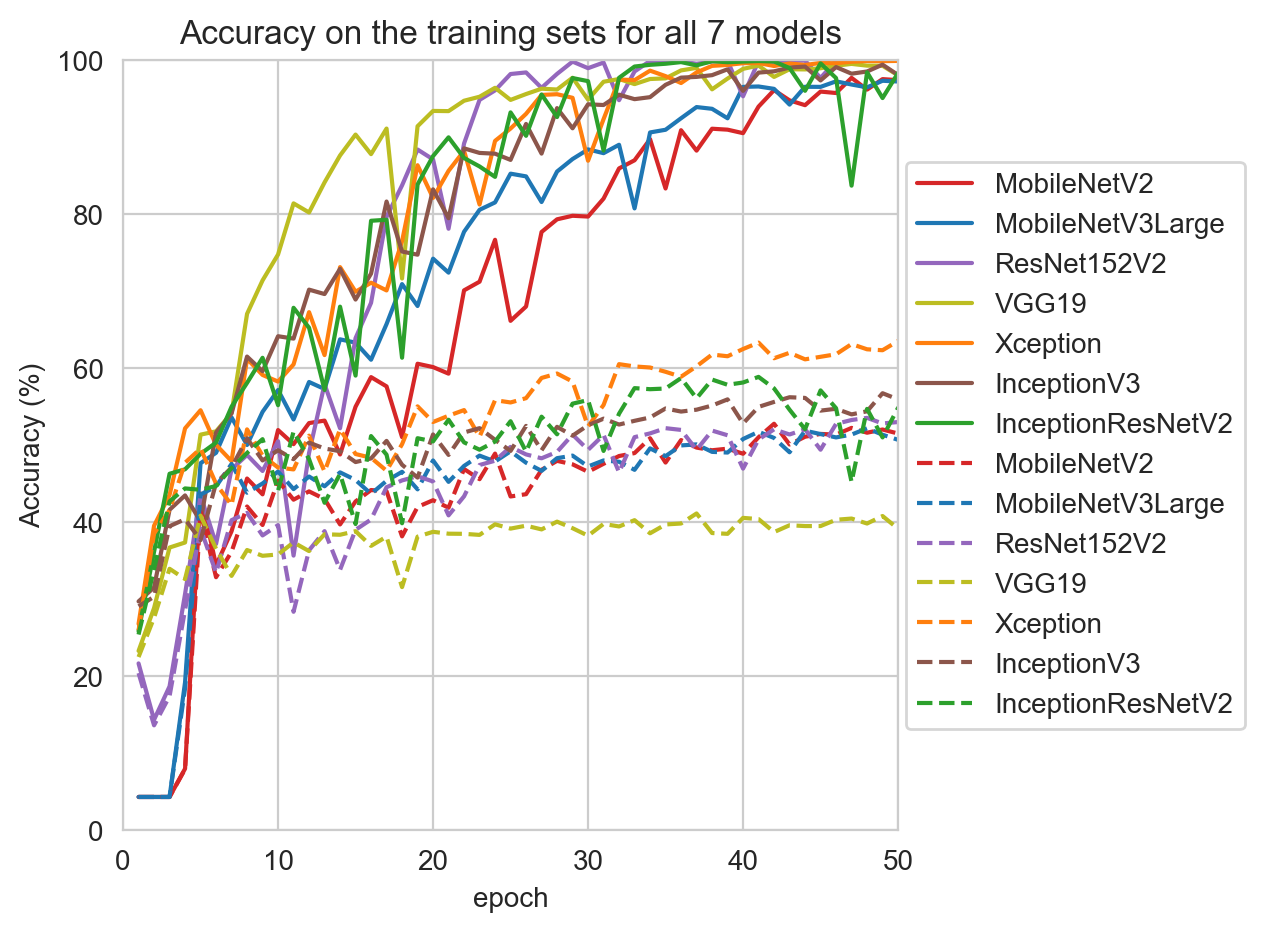

In [223]:
mpl.rcParams['figure.dpi'] = 200

f = plt.figure(figsize=(5, 5))
x = np.arange(1, 51)
x1 = np.arange(1, 101)
# x1 = np.arange(1, len(MobileNetV2ModelData[0])+1)
plt.plot(np.arange(1, len(MobileNetV2ModelData[0])+1), np.array(MobileNetV2ModelData[0]) * 100, label='MobileNetV2', color='tab:red')
plt.plot(x1, np.array(MobileNetV3LargeModelData[0]) * 100, label='MobileNetV3Large', color='tab:blue')
plt.plot(x, np.array(ResNet152V2ModelData[0]) * 100, label='ResNet152V2', color='tab:purple')
plt.plot(x1, np.array(VGG19ModelData[0]) * 100, color='tab:olive', label='VGG19')
plt.plot(np.arange(1, len(XceptionModelData[0])+1), np.array(XceptionModelData[0]) * 100, color='tab:orange', label='Xception')
plt.plot(x1, np.array(InceptionV3ModelData[0]) * 100, color='tab:brown', label='InceptionV3')
plt.plot(x1, np.array(InceptionResNetV2ModelData[0]) * 100, color='tab:green', label='InceptionResNetV2')

plt.plot(np.arange(1, len(MobileNetV2ModelData[2])+1), np.array(MobileNetV2ModelData[2]) * 100, label='MobileNetV2', color='tab:red', linestyle='--')
plt.plot(x1, np.array(MobileNetV3LargeModelData[2]) * 100, label='MobileNetV3Large', color='tab:blue', linestyle='--')
plt.plot(x, np.array(ResNet152V2ModelData[2]) * 100, label='ResNet152V2', color='tab:purple', linestyle='--')
plt.plot(x1, np.array(VGG19ModelData[2]) * 100, color='tab:olive', label='VGG19', linestyle='--')
plt.plot(np.arange(1, len(XceptionModelData[2])+1), np.array(XceptionModelData[2]) * 100, color='tab:orange', label='Xception', linestyle='--')
plt.plot(x1, np.array(InceptionV3ModelData[2]) * 100, color='tab:brown', label='InceptionV3', linestyle='--')
plt.plot(x1, np.array(InceptionResNetV2ModelData[2]) * 100, color='tab:green', label='InceptionResNetV2', linestyle='--')

plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy on the training sets for all 7 models")
plt.xlim(0, 50)
plt.ylim(0, 100)

# Training on augments (Unused)
This section covers training a model on the various augmented datasets. It was not successful and no further work was done on it.

In [37]:
print("Importing Datasets...")
# train_ds_aug, validation_ds_aug, test_ds_aug = import_datasets(20, data_split_blurred, image_size_299)
# train_ds_aug, validation_ds_aug, test_ds_aug = import_datasets(20, data_split_greyscale, image_size_299)
train_ds_aug, validation_ds_aug, test_ds_aug = import_datasets(20, data_split_greyscale_blur, image_size_299)

Importing Datasets...
Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [38]:
from keras.applications import Xception
XceptionModelAug = create_model(no_classes, Xception)
# XceptionModelAug, _, callbacks = compile_model(parent_directory, XceptionModelAug, 'Xception_blur', loss='categorical_crossentropy', optimizer='SGD')
# XceptionModelAug, _, callbacks = compile_model(parent_directory, XceptionModelAug, 'Xception_greyscale', loss='categorical_crossentropy', optimizer='SGD')
XceptionModelAug, _, callbacks = compile_model(parent_directory, XceptionModelAug, 'Xception_greyscale_blur', loss='categorical_crossentropy', optimizer='SGD')
# XceptionModelAug, _, callbacks = compile_model(parent_directory, XceptionModelAug, 'Xception_vignette', loss='categorical_crossentropy', optimizer='SGD')

In [39]:
XceptionModelAug.fit(train_ds_aug, epochs=50, callbacks=callbacks, validation_data=validation_ds_aug)

Epoch 1/50
2300/2300 [==============================] - 872s 376ms/step - loss: 2.3785 - accuracy: 0.2938 - val_loss: 3.2382 - val_accuracy: 0.1619
Epoch 2/50
2300/2300 [==============================] - 864s 376ms/step - loss: 2.0117 - accuracy: 0.3990 - val_loss: 2.1676 - val_accuracy: 0.3598
Epoch 3/50
2300/2300 [==============================] - 866s 377ms/step - loss: 1.7946 - accuracy: 0.4580 - val_loss: 2.0315 - val_accuracy: 0.4092
Epoch 4/50
2300/2300 [==============================] - 866s 377ms/step - loss: 1.6291 - accuracy: 0.5075 - val_loss: 2.1294 - val_accuracy: 0.3897
Epoch 5/50
2300/2300 [==============================] - 873s 379ms/step - loss: 1.4871 - accuracy: 0.5471 - val_loss: 2.1014 - val_accuracy: 0.4120
Epoch 6/50
2300/2300 [==============================] - 873s 379ms/step - loss: 1.3684 - accuracy: 0.5815 - val_loss: 1.7898 - val_accuracy: 0.4814
Epoch 7/50
2300/2300 [==============================] - 866s 377ms/step - loss: 1.2515 - accuracy: 0.6157 - val_

KeyboardInterrupt: 

# Ensemble model (Unused)
This aimed to use one model to differentiate between the easy and hard classes and another two to recognise each class in each of the 'hard' and 'easy' sets. After initial tests it was shown to be a complete failure and no further work was done it. It only succeeded at producing a mediocre increase the 'easy' categories and overall decreased accuracy to sub 40% levels overall. This is not included in the report.

## Ensemble Functions
These functions prepare the images in the primary (easy) and secondary (hard) sets of categories in the dataset. There is also a function to do this in parallel which speeds up the process a lot.

In [25]:
def prepare_primary(classes_set: np.ndarray, source, destination, im_size=(224, 224)):

    for category in classes_set:
        make_folder(destination)

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'

            make_folder(f'{destination}/1/primary/{category}')
            file_path_modified_1a = f'{destination}/1/primary/{category}/{image_name}'
            file_path_modified_1b = f'{destination}/1/binary/primary/{image_name}'

            make_folder(f'{destination}/2/primary/{category}')
            make_folder(f'{destination}/2/secondary/None')
            file_path_modified_2a = f'{destination}/2/primary/{category}/{image_name}'
            file_path_modified_2b = f'{destination}/2/secondary/None/{image_name}'

            make_folder(f'{destination}/3/primary/{category}')
            file_path_modified_3 = f'{destination}/3/primary/{category}/{image_name}'

            img = Image.open(file_path)
            img = img.resize(im_size)

            try:
                img = img.convert('RGB')
                img.save(file_path_modified_1a)
                img.save(file_path_modified_1b)
                img.save(file_path_modified_2a)
                img.save(file_path_modified_2b)
                img.save(file_path_modified_3)
                pass
            except Exception as error:
                print(error)
                pass

def prepare_secondary(classes_set: np.ndarray, source, destination, im_size=(224, 224)):

    for category in classes_set:
        make_folder(destination)

        for image_name in os.listdir(f'{source}/{category}'):
            file_path = f'{source}/{category}/{image_name}'

            make_folder(f'{destination}/1/secondary/{category}')
            file_path_modified_1a = f'{destination}/1/secondary/{category}/{image_name}'
            file_path_modified_1b = f'{destination}/1/binary/secondary/{image_name}'
            make_folder(f'{destination}/2/secondary/{category}')
            make_folder(f'{destination}/2/primary/None')
            file_path_modified_2a = f'{destination}/2/secondary/{category}/{image_name}'
            file_path_modified_2b = f'{destination}/2/primary/None/{image_name}'
            make_folder(f'{destination}/3/secondary/{category}')
            file_path_modified_3 = f'{destination}/3/secondary/{category}/{image_name}'

            img = Image.open(file_path)
            img = img.resize(im_size)

            try:
                img = img.convert('RGB')
                img.save(file_path_modified_1a)
                img.save(file_path_modified_1b)
                img.save(file_path_modified_2a)
                img.save(file_path_modified_2b)
                img.save(file_path_modified_3)
                pass
            except Exception as error:
                print(error)
                pass

def parallel_prepare_ensemble(classes, input_dir, output_dir, im_size, is_primary: bool, max_threads=16):
    classes = np.array(classes)
    num_classes = classes.size

    # cleanup_folder(output_dir)
    # make_folder(output_dir)

    if max_threads < num_classes:
        no_threads = max_threads
        classes_per_thread = num_classes // max_threads
        split_indices = np.arange(classes_per_thread, num_classes - classes_per_thread, classes_per_thread)
        split_classes = np.split(classes, split_indices)
    else:
        split_indices = np.arange(1, num_classes)
        split_classes = np.split(classes, split_indices)
        no_threads = num_classes

    start_time = time.time()
    if is_primary:
        Parallel(n_jobs=no_threads,
                 verbose=0  # Verbose is how many progress messages
                 )(delayed(prepare_primary)
                   (classes_set, input_dir, output_dir, im_size=im_size)
                   for classes_set in
                   split_classes)
    else:
        Parallel(n_jobs=no_threads,
                 verbose=0  # Verbose is how many progress messages
                 )(delayed(prepare_secondary)
                   (classes_set, input_dir, output_dir, im_size=im_size)
                   for classes_set in
                   split_classes)
    duration = time.time() - start_time

    print(f'{duration}s taken for resizing, cropping and padding the dataset')

def make_split_class_list(class_names, classes_to_remove):

    primary_set = class_names.copy()
    for class_name in classes_to_remove:
        primary_set.remove(class_name)

    secondary_set = classes_to_remove
    return primary_set, secondary_set

## Ensemble setup
Here we set up the folders required for each different subset of the MINC-2500 dataset

In [ ]:
# cleanup_folder(directory_ensemble)

make primary and secondary lists and create folder names

In [26]:
primary_set, secondary_set = make_split_class_list(class_names, ['fabric', "ceramic", "glass", "metal", "other", "paper", "plastic", "stone", "tile", "wallpaper"])
primary_set_size, secondary_set_size = len(primary_set), len(secondary_set)

directory_parent = "C:/MLDatasets/"
directory_ensemble = directory_parent+"/minc-2500/ensemble_methods"
directory_ensemble_1 = directory_ensemble+"/1"
directory_ensemble_1_primary = directory_ensemble_1+"/primary"
directory_ensemble_1_secondary = directory_ensemble_1+"/secondary"
directory_ensemble_1_binary = directory_ensemble_1+"/binary"
directory_ensemble_1_binary_primary = directory_ensemble_1_binary+"/primary"
directory_ensemble_1_binary_secondary = directory_ensemble_1_binary+"/secondary"

directory_ensemble_2 = directory_ensemble+"/2"
directory_ensemble_2_primary = directory_ensemble_2+"/primary"
directory_ensemble_2_secondary = directory_ensemble_2+"/secondary"

directory_ensemble_3 = directory_ensemble+"/3"
directory_ensemble_3_primary = directory_ensemble_3+"/primary"
directory_ensemble_3_secondary = directory_ensemble_3+"/secondary"

directory_ensemble_1_primary_split = directory_ensemble_1_primary+"_split"
directory_ensemble_1_secondary_split = directory_ensemble_1_secondary+"_split"
directory_ensemble_1_binary_split = directory_ensemble_1_binary+"_split"

directory_ensemble_2_primary_split = directory_ensemble_2_primary+"_split"
directory_ensemble_2_secondary_split = directory_ensemble_2_secondary+"_split"

directory_ensemble_3_primary_split = directory_ensemble_1_primary+"_split"
directory_ensemble_3_secondary_split = directory_ensemble_1_secondary+"_split"

Make the new folders

In [ ]:
make_folder(directory_ensemble)
make_folder(directory_ensemble_1)
make_folder(directory_ensemble_1_primary)
make_folder(directory_ensemble_1_secondary)
make_folder(directory_ensemble_1_binary)
make_folder(directory_ensemble_1_binary_primary)
make_folder(directory_ensemble_1_binary_secondary)

make_folder(directory_ensemble_2)
make_folder(directory_ensemble_2_primary)
make_folder(directory_ensemble_2_secondary)

make_folder(directory_ensemble_3)
make_folder(directory_ensemble_3_primary)
make_folder(directory_ensemble_3_secondary)

Prepare the primary and secondary sets in parallel and split the data into train, test and validation splits.

In [ ]:
parallel_prepare_ensemble(primary_set, data_source, directory_ensemble, image_size, is_primary=True)
parallel_prepare_ensemble(secondary_set, data_source, directory_ensemble, image_size, is_primary=False)

In [27]:
directories = [directory_ensemble_1_binary, directory_ensemble_1_primary, directory_ensemble_1_secondary]

In [39]:
split_in_parallel(directories)

In [ ]:
directories2 = [directory_ensemble_2_primary, directory_ensemble_2_secondary]
split_in_parallel(directories2)

Cleanup and remove all ensemble images when not required anymore

In [32]:
for dir in directories:
    cleanup_folder(dir+"_split")

Deletion took 1 tries
Deletion took 1 tries
Deletion took 1 tries
Directory doesn't exist
Directory doesn't exist
Directory doesn't exist
Directory doesn't exist


## Ensemble models

### Model 1
This uses a binary classifier to recognise the easy and hard objects then another classifier for the easy and hard sets

#### Import datasets
Each model uses a different subset

In [41]:
# train_ds_b, validation_ds_b, test_ds_b = import_datasets(32, directory_ensemble_1_binary_split, image_size)
# train_ds_p, validation_ds_p, test_ds_p = import_datasets(32, directory_ensemble_1_primary_split, image_size)
# train_ds_s, validation_ds_s, test_ds_s = import_datasets(32, directory_ensemble_1_secondary_split, image_size)

Found 46000 files belonging to 2 classes.
Found 5750 files belonging to 2 classes.
Found 5750 files belonging to 2 classes.


Create the classifiers for primary and secondary

In [ ]:
from keras.applications import MobileNetV3Small, MobileNetV3Large

binary_classifier = create_model(2, MobileNetV3Large)

In [42]:
primary_classifier = create_model(primary_set_size, MobileNetV3Large)
secondary_classifier = create_model(secondary_set_size, MobileNetV3Large)

In [43]:
binary_classifier, _, callbacks = compile_model(parent_directory, binary_classifier, 'Ensemble_1_binary')

In [44]:
train_ds_b, validation_ds_b, test_ds_b = import_datasets(32, directory_ensemble_1_binary_split, image_size)

Found 46000 files belonging to 2 classes.
Found 5750 files belonging to 2 classes.
Found 5750 files belonging to 2 classes.


Train the models

In [45]:
binary_classifier.fit(train_ds_b, epochs=50, callbacks=callbacks, validation_data=validation_ds_b)

Epoch 1/50
1438/1438 [==============================] - 214s 145ms/step - loss: 0.6660 - accuracy: 0.5805 - val_loss: 0.6884 - val_accuracy: 0.5652
Epoch 2/50
1438/1438 [==============================] - 207s 144ms/step - loss: 0.6479 - accuracy: 0.6061 - val_loss: 0.6891 - val_accuracy: 0.5652
Epoch 3/50
1438/1438 [==============================] - 208s 144ms/step - loss: 0.6307 - accuracy: 0.6283 - val_loss: 0.6893 - val_accuracy: 0.5652
Epoch 4/50
1438/1438 [==============================] - 208s 144ms/step - loss: 0.6131 - accuracy: 0.6503 - val_loss: 0.6798 - val_accuracy: 0.6179
Epoch 5/50
1438/1438 [==============================] - 208s 144ms/step - loss: 0.5993 - accuracy: 0.6686 - val_loss: 0.6186 - val_accuracy: 0.6435
Epoch 6/50
1438/1438 [==============================] - 211s 146ms/step - loss: 0.5838 - accuracy: 0.6790 - val_loss: 0.6619 - val_accuracy: 0.6423
Epoch 7/50
1438/1438 [==============================] - 210s 146ms/step - loss: 0.5725 - accuracy: 0.6910 - val_

KeyboardInterrupt: 

In [38]:
resume_from = 31
binary_classifier.load_weights(f"{parent_directory}minc-training/Ensemble_1_binary_{resume_from}.h5")

In [39]:
binary_classifier.fit(train_ds_b, epochs=50, callbacks=callbacks, validation_data=validation_ds_b, initial_epoch=resume_from)

Epoch 32/50
1438/1438 [==============================] - 121s 81ms/step - loss: 0.2150 - accuracy: 0.9068 - val_loss: 1.2930 - val_accuracy: 0.6360
Epoch 33/50
1438/1438 [==============================] - 110s 76ms/step - loss: 0.2106 - accuracy: 0.9102 - val_loss: 1.3067 - val_accuracy: 0.6336
Epoch 34/50
1438/1438 [==============================] - 111s 77ms/step - loss: 0.2022 - accuracy: 0.9153 - val_loss: 1.2629 - val_accuracy: 0.6343
Epoch 35/50
1438/1438 [==============================] - 110s 76ms/step - loss: 0.1911 - accuracy: 0.9210 - val_loss: 1.3170 - val_accuracy: 0.6350
Epoch 36/50
1438/1438 [==============================] - 110s 76ms/step - loss: 0.1885 - accuracy: 0.9217 - val_loss: 1.3382 - val_accuracy: 0.6490
Epoch 37/50
1438/1438 [==============================] - 111s 77ms/step - loss: 0.1713 - accuracy: 0.9289 - val_loss: 1.3354 - val_accuracy: 0.6268
Epoch 38/50
1438/1438 [==============================] - 110s 76ms/step - loss: 0.1680 - accuracy: 0.9306 - val_

In [40]:
train_ds_p, validation_ds_p, test_ds_p = import_datasets(32, directory_ensemble_1_primary_split, image_size)
primary_classifier, _, callbacks = compile_model(parent_directory, primary_classifier, 'Ensemble_1_primary')
primary_classifier.fit(train_ds_p, epochs=50, callbacks=callbacks, validation_data=validation_ds_p)

Found 26000 files belonging to 13 classes.
Found 3250 files belonging to 13 classes.
Found 3250 files belonging to 13 classes.
Epoch 1/50
813/813 [==============================] - 126s 148ms/step - loss: 1.8493 - accuracy: 0.3872 - val_loss: 2.5693 - val_accuracy: 0.0769
Epoch 2/50
813/813 [==============================] - 119s 146ms/step - loss: 1.3875 - accuracy: 0.5418 - val_loss: 2.5771 - val_accuracy: 0.0769
Epoch 3/50
813/813 [==============================] - 118s 145ms/step - loss: 1.2084 - accuracy: 0.6048 - val_loss: 2.5932 - val_accuracy: 0.0769
Epoch 4/50
813/813 [==============================] - 118s 145ms/step - loss: 1.0861 - accuracy: 0.6393 - val_loss: 2.6298 - val_accuracy: 0.0769
Epoch 5/50
813/813 [==============================] - 118s 145ms/step - loss: 0.9895 - accuracy: 0.6698 - val_loss: 2.6623 - val_accuracy: 0.0769
Epoch 6/50
813/813 [==============================] - 119s 145ms/step - loss: 0.9187 - accuracy: 0.6914 - val_loss: 2.5822 - val_accuracy: 0.10

In [41]:
train_ds_s, validation_ds_s, test_ds_s = import_datasets(32, directory_ensemble_1_secondary_split, image_size)
secondary_classifier, _, callbacks = compile_model(parent_directory, secondary_classifier, 'Ensemble_1_secondary')
secondary_classifier.fit(train_ds_s, epochs=50, callbacks=callbacks, validation_data=validation_ds_s)

Found 20000 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Epoch 1/50
625/625 [==============================] - 97s 146ms/step - loss: 2.0325 - accuracy: 0.2697 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 90s 144ms/step - loss: 1.8402 - accuracy: 0.3485 - val_loss: 2.3048 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 90s 144ms/step - loss: 1.7130 - accuracy: 0.4013 - val_loss: 2.3081 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 90s 144ms/step - loss: 1.6070 - accuracy: 0.4480 - val_loss: 2.3155 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 90s 144ms/step - loss: 1.5344 - accuracy: 0.4709 - val_loss: 2.3239 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 90s 144ms/step - loss: 1.4597 - accuracy: 0.4947 - val_loss: 2.3225 - val_accuracy: 0.1000
Epo

# Using pre-trained weights
Here we train the most promising models from the previous section with pretrained weights trained on ImageNet.

## MobileNetV3Large

In [ ]:
train_ds, validation_ds, test_ds = import_datasets(32, data_split, image_size)

In [ ]:
from keras.applications import MobileNetV3Large
MobileNetV3LargeModelImagenet = create_flip_model(no_classes, MobileNetV3Large, 'imagenet', image_size)
MobileNetV3LargeModelImagenet, _, callbacks = compile_model(parent_directory, MobileNetV3LargeModelImagenet, 'MobileNetV3Large_imagenet', loss='categorical_crossentropy', optimizer='SGD')
MobileNetV3LargeModelImagenet.summary()

In [53]:
MobileNetV3LargeModelImagenet.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/50
1438/1438 [==============================] - 214s 143ms/step - loss: 1.3435 - accuracy: 0.5960 - val_loss: 0.9310 - val_accuracy: 0.7237
Epoch 2/50
1438/1438 [==============================] - 203s 141ms/step - loss: 0.7538 - accuracy: 0.7629 - val_loss: 0.7653 - val_accuracy: 0.7649
Epoch 3/50
1438/1438 [==============================] - 205s 143ms/step - loss: 0.6003 - accuracy: 0.8100 - val_loss: 0.7069 - val_accuracy: 0.7821
Epoch 4/50
1438/1438 [==============================] - 207s 144ms/step - loss: 0.4911 - accuracy: 0.8436 - val_loss: 0.6852 - val_accuracy: 0.7943
Epoch 5/50
1438/1438 [==============================] - 206s 143ms/step - loss: 0.4068 - accuracy: 0.8704 - val_loss: 0.7042 - val_accuracy: 0.7901
Epoch 6/50
1438/1438 [==============================] - 205s 142ms/step - loss: 0.3304 - accuracy: 0.8962 - val_loss: 0.7125 - val_accuracy: 0.8000
Epoch 7/50
1438/1438 [==============================] - 207s 144ms/step - loss: 0.2625 - accuracy: 0.9179 - val_

KeyboardInterrupt: 

## Xception

In [170]:
train_ds_299, validation_ds_299, test_ds_299 = import_datasets(20, data_split_299, image_size_299)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [152]:
# train_ds, validation_ds, test_ds = import_datasets(32, data_split, image_size)

XceptionModelImagenet = create_no_top_model(no_classes, Xception, 'imagenet')
print(XceptionModelImagenet.summary())
XceptionModelImagenet, _, callbacks = compile_model(parent_directory, XceptionModelImagenet, 'Xception_imagenet', loss='categorical_crossentropy', optimizer='SGD')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_4 (Dense)             (None, 23)                47127     
                                                                 
Total params: 20,908,607
Trainable params: 20,854,079
Non-trainable params: 54,528
_________________________________________________________________
None


In [74]:
XceptionModelImagenet.fit(train_ds_299, epochs=50, callbacks=callbacks, validation_data=validation_ds_299)

Epoch 1/50
2300/2300 [==============================] - 911s 391ms/step - loss: 1.3785 - accuracy: 0.6153 - val_loss: 0.7903 - val_accuracy: 0.7597
Epoch 2/50
2300/2300 [==============================] - 877s 381ms/step - loss: 0.6848 - accuracy: 0.7907 - val_loss: 0.6491 - val_accuracy: 0.7998
Epoch 3/50
2300/2300 [==============================] - 896s 390ms/step - loss: 0.4576 - accuracy: 0.8638 - val_loss: 0.6216 - val_accuracy: 0.8125
Epoch 4/50
2300/2300 [==============================] - 879s 382ms/step - loss: 0.2980 - accuracy: 0.9121 - val_loss: 0.6521 - val_accuracy: 0.8150
Epoch 5/50
2300/2300 [==============================] - 879s 382ms/step - loss: 0.1852 - accuracy: 0.9487 - val_loss: 0.6970 - val_accuracy: 0.8151
Epoch 6/50
2300/2300 [==============================] - 879s 382ms/step - loss: 0.1115 - accuracy: 0.9703 - val_loss: 0.7320 - val_accuracy: 0.8136
Epoch 7/50
2300/2300 [==============================] - 899s 391ms/step - loss: 0.0721 - accuracy: 0.9818 - val_

In [ ]:
resume_from = 50
XceptionModelImagenet.load_weights(f"{parent_directory}minc-training/Xception_imagenet_{resume_from}.h5")
XceptionModelImagenet.fit(train_ds_299, epochs=100, callbacks=callbacks, validation_data=validation_ds_299, initial_epoch=resume_from)

## InceptionResnetV2

In [33]:
train_ds_299, validation_ds_299, test_ds_299 = import_datasets(24, data_split_299, image_size_299)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [153]:
InceptionResNetV2ModelImagenet = create_no_top_model(no_classes, InceptionResNetV2, 'imagenet')
print(InceptionResNetV2ModelImagenet.summary())
InceptionResNetV2ModelImagenet, _, callbacks = compile_model(parent_directory, InceptionResNetV2ModelImagenet, 'InceptionResNetV2_imagenet', loss='categorical_crossentropy', optimizer='SGD')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 23)                35351     
                                                                 
Total params: 54,372,087
Trainable params: 54,311,543
Non-trainable params: 60,544
_________________________________________________________________
None


In [37]:
InceptionResNetV2ModelImagenet.fit(train_ds_299, epochs=50, callbacks=callbacks, validation_data=validation_ds_299)

Epoch 1/50
1917/1917 [==============================] - 919s 469ms/step - loss: 1.1111 - accuracy: 0.6750 - val_loss: 0.6712 - val_accuracy: 0.7976
Epoch 2/50
1917/1917 [==============================] - 899s 468ms/step - loss: 0.5540 - accuracy: 0.8305 - val_loss: 0.5902 - val_accuracy: 0.8242
Epoch 3/50
1917/1917 [==============================] - 875s 456ms/step - loss: 0.3506 - accuracy: 0.8941 - val_loss: 0.5936 - val_accuracy: 0.8310
Epoch 4/50
1917/1917 [==============================] - 902s 470ms/step - loss: 0.2189 - accuracy: 0.9351 - val_loss: 0.6379 - val_accuracy: 0.8299
Epoch 5/50
1917/1917 [==============================] - 905s 472ms/step - loss: 0.1414 - accuracy: 0.9571 - val_loss: 0.6802 - val_accuracy: 0.8306
Epoch 6/50
1917/1917 [==============================] - 887s 463ms/step - loss: 0.0970 - accuracy: 0.9713 - val_loss: 0.7212 - val_accuracy: 0.8261
Epoch 7/50
1917/1917 [==============================] - 904s 471ms/step - loss: 0.0697 - accuracy: 0.9790 - val_

## Evaluation
Here we extract all the model data and graph it. The model data is also saved to avoid re-running inference

In [154]:
datasets = import_datasets(32, data_split, image_size)

MobileNetV3LargeModelImagenet.load_weights(f"{parent_directory}minc-training/MobileNetV3Large_imagenet_{1}.h5")
MobileNetV3LargeModelImagenetData = test_every_epoch(MobileNetV3LargeModelImagenet, "MobileNetV3Large_imagenet", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1438/1438 [==============================] - 58s 40ms/step - loss: 0.0016 - accuracy: 0.9998
Ending at epoch 39!


Text(0.5, 1.0, 'Confusion matrix for MobileNetV3Large')

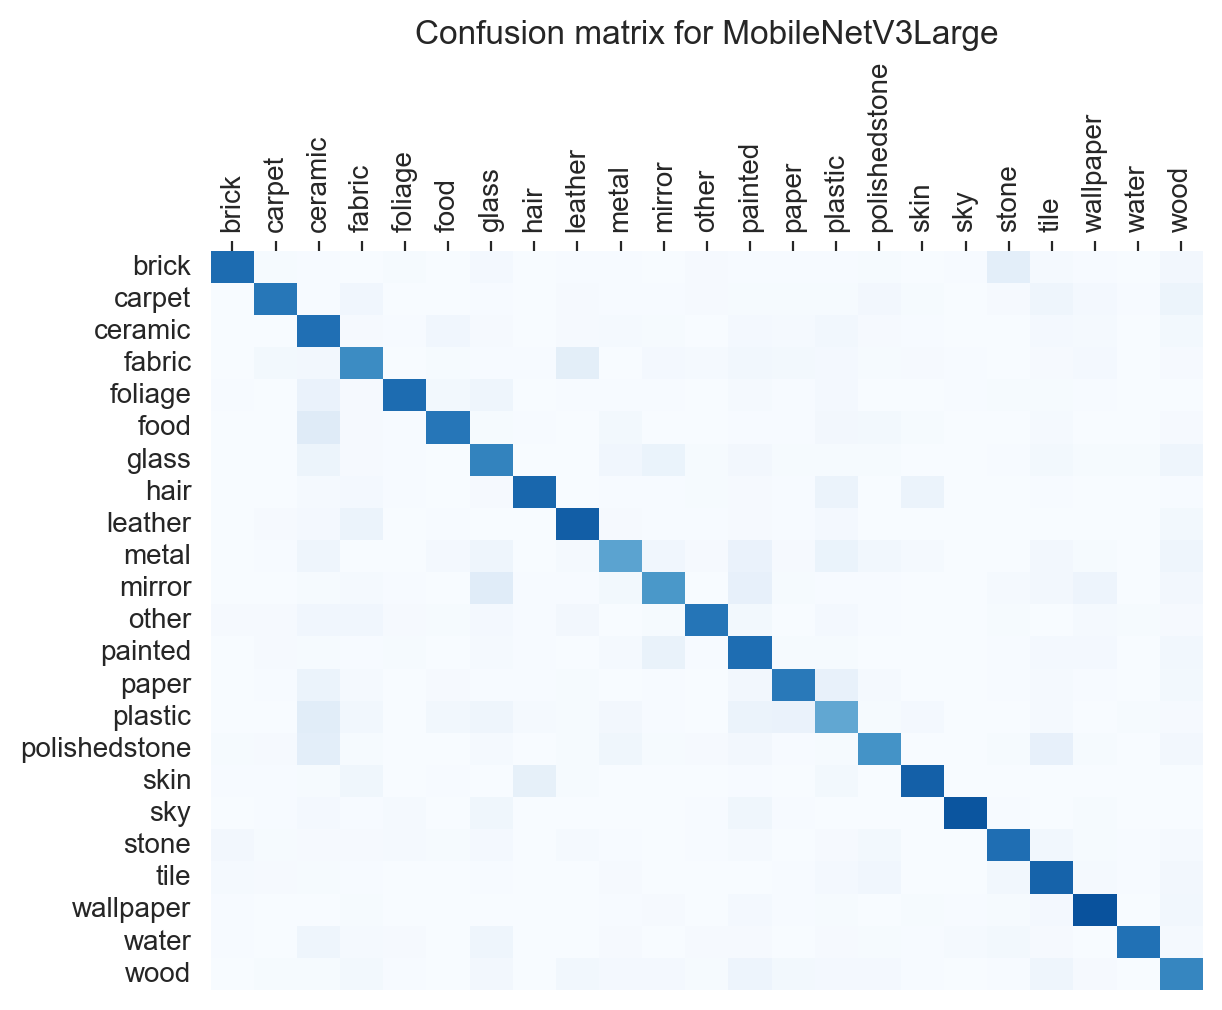

In [168]:
conf = graph_confusion_matrix('MobileNetV3Large_imagenet', 38, f'{parent_directory}minc-training', image_size, classes=class_names, set=datasets[2])
plt.title("Confusion matrix for MobileNetV3Large")

In [155]:
datasets = import_datasets(20, data_split_299, image_size_299)
XceptionModelImagenet.load_weights(f"{parent_directory}minc-training/Xception_imagenet_{1}.h5")
XceptionModelImagenetData = test_every_epoch(XceptionModelImagenet, "Xception_imagenet", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
2300/2300 [==============================] - 185s 80ms/step - loss: 2.7269e-04 - accuracy: 1.0000
Ending at epoch 51!


Text(0.5, 1.0, 'Confusion matrix for Xception')

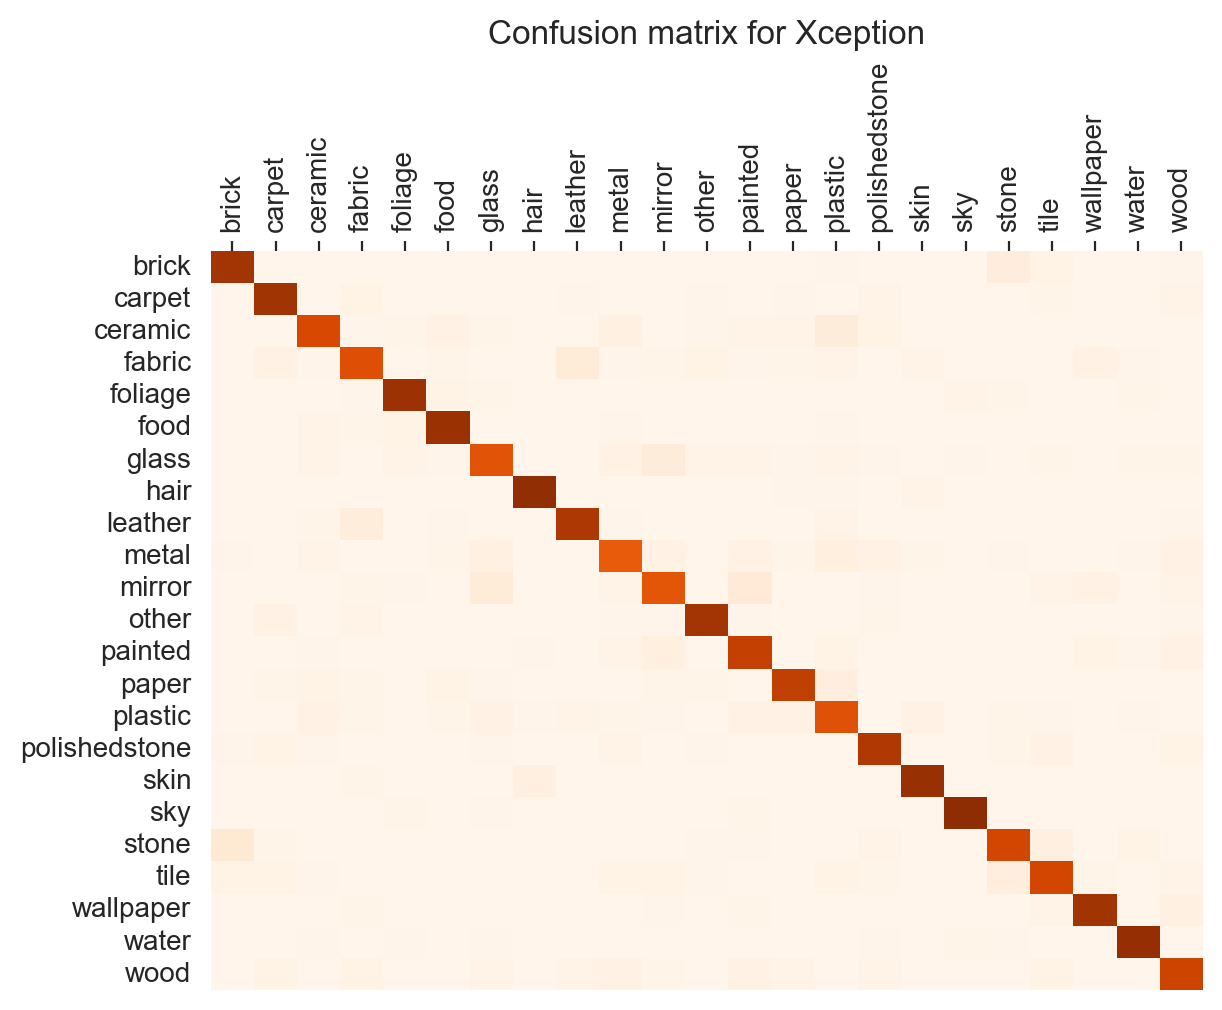

In [172]:
conf = graph_confusion_matrix('Xception_imagenet', 50, f'{parent_directory}minc-training', image_size, classes=class_names, set=datasets[2], colour_palette='Oranges')
plt.title("Confusion matrix for Xception")

In [156]:
datasets = import_datasets(24, data_split_299, image_size_299)
InceptionResNetV2ModelImagenet.load_weights(f"{parent_directory}minc-training/InceptionResNetV2_imagenet_{1}.h5")
InceptionResNetV2ModelImagenetData = test_every_epoch(InceptionResNetV2ModelImagenet, "InceptionResNetV2_imagenet", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
1917/1917 [==============================] - 299s 156ms/step - loss: 9.9110e-04 - accuracy: 0.9997
Ending at epoch 51!


In [151]:
from keras.applications import MobileNetV3Large
MobileNetV3LargeModelImagenet = create_no_top_model(no_classes, MobileNetV3Large, 'imagenet')
print(MobileNetV3LargeModelImagenet.summary())
MobileNetV3LargeModelImagenet, _, callbacks = compile_model(parent_directory, MobileNetV3LargeModelImagenet, 'MobileNetV3Large_imagenet', loss='categorical_crossentropy', optimizer='SGD')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 23)                22103     
                                                                 
Total params: 3,018,455
Trainable params: 2,994,055
Non-trainable params: 24,400
_________________________________________________________________
None


Text(0.5, 1.0, 'Confusion matrix for InceptionResNetV2')

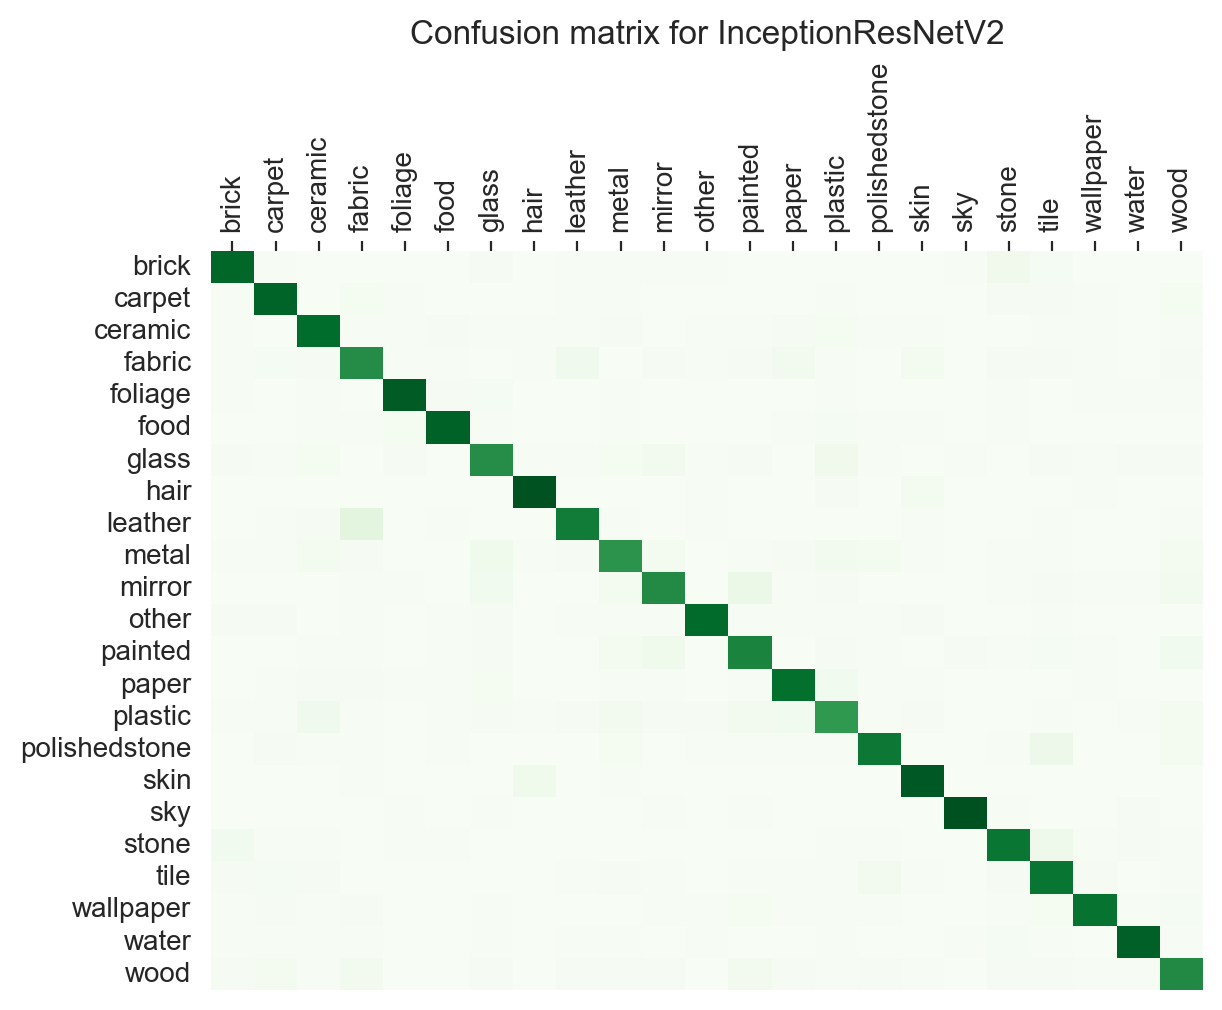

In [173]:
conf = graph_confusion_matrix('InceptionResNetV2_imagenet', 50, f'{parent_directory}minc-training/', image_size_299, classes=class_names, set=validation_ds_299, colour_palette='Greens')
plt.title("Confusion matrix for InceptionResNetV2")

(65.0, 100.0)

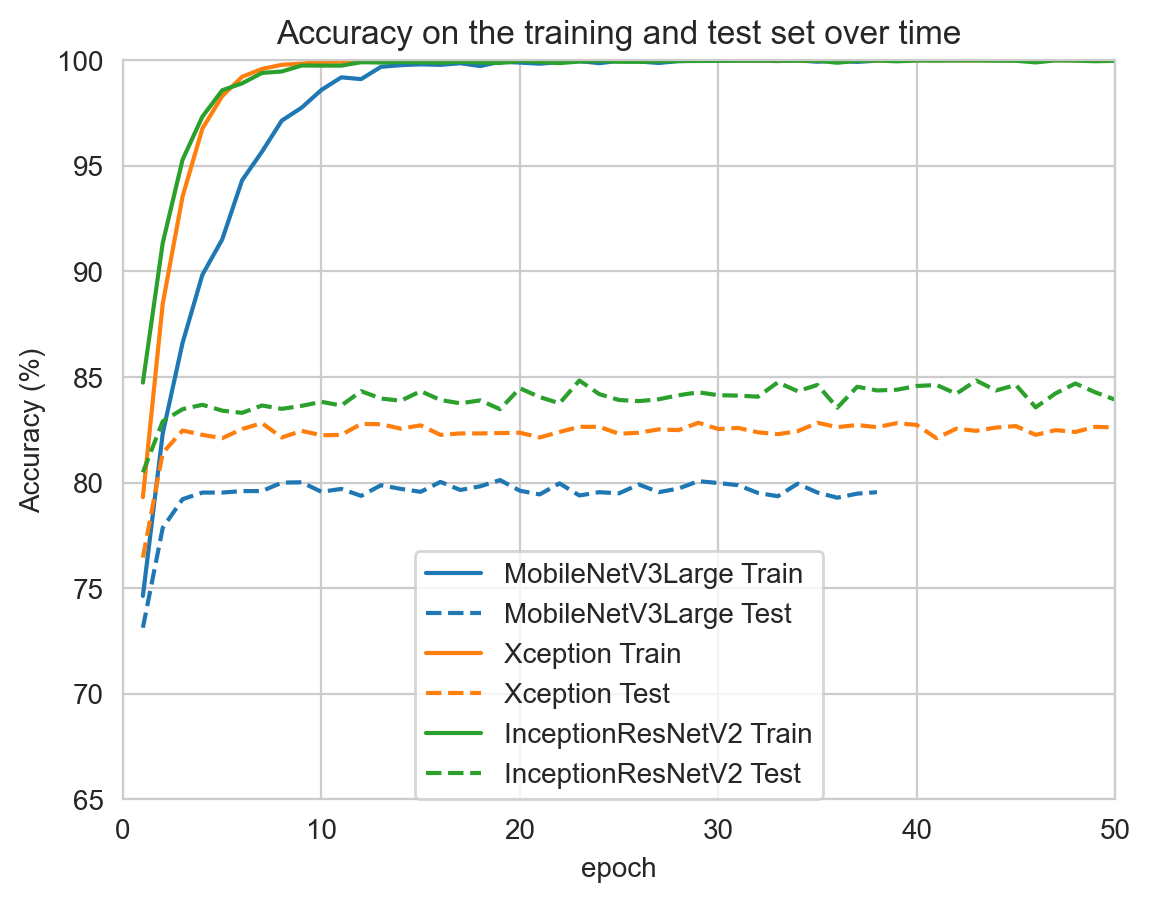

In [167]:
mpl.rcParams['figure.dpi'] = 200

x = np.arange(1, 51)
x1 = np.arange(1, len(MobileNetV3LargeModelImagenetData[0])+1)
plt.plot(x1, np.array(MobileNetV3LargeModelImagenetData[0]) * 100, label='MobileNetV3Large Train', color='tab:blue')
plt.plot(x1, np.array(MobileNetV3LargeModelImagenetData[2]) * 100, label='MobileNetV3Large Test', color='tab:blue', linestyle='--')
plt.plot(x, np.array(XceptionModelImagenetData[0]) * 100, color='tab:orange', label='Xception Train')
plt.plot(x, np.array(XceptionModelImagenetData[2]) * 100, color='tab:orange', label='Xception Test', linestyle='--')
plt.plot(x, np.array(InceptionResNetV2ModelImagenetData[0]) * 100, color='tab:green', label='InceptionResNetV2 Train')
# plt.plot(x, np.array(InceptionResNetV2ModelFlipData[1]) * 100, color='tab:green', label='InceptionResNetV2Val', linestyle='--')
plt.plot(x, np.array(InceptionResNetV2ModelImagenetData[2]) * 100, color='tab:green', label='InceptionResNetV2 Test', linestyle='--')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0), borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy on the training and test set over time")
plt.xlim(0, 50)
plt.ylim(65, 100)

In [197]:
np.save('MobileNetV3Large_imagenet', np.array(MobileNetV3LargeModelImagenetData))
np.save('Xception_imagenet', np.array(XceptionModelImagenetData))
np.save('InceptionResNetV2_imagenet', np.array(InceptionResNetV2ModelImagenetData))

# Train with random flipping and rotation
This will only train the best 3 models again with the training images being randomly flipped and rotated. These are:
- Xception
- MobileNetV3Large
- InceptionResNetV2

## MobileNetV3Large

In [90]:
train_ds, validation_ds, test_ds = import_datasets(32, data_split, image_size)
# train_ds = prepare(train_ds, shuffle=True, augment=True, batch_size=32)
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=32)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [77]:
from keras.applications import MobileNetV3Large
MobileNetV3LargeModelFlip = create_flip_model(no_classes, MobileNetV3Large, 'imagenet', image_size)
MobileNetV3LargeModelFlip, _, callbacks = compile_model(parent_directory, MobileNetV3LargeModelFlip, 'MobileNetV3Large_Flip', loss='categorical_crossentropy', optimizer='SGD')
MobileNetV3LargeModelFlip.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 23)                22103     
                                                                 
Total params: 3,018,455
Trainable params: 2,994,055
Non-trainable params: 24,400
_________________________________________________________________


In [92]:
MobileNetV3LargeModelFlip.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/50
1438/1438 [==============================] - 313s 205ms/step - loss: 1.6171 - accuracy: 0.5156 - val_loss: 1.1306 - val_accuracy: 0.6680
Epoch 2/50
1438/1438 [==============================] - 298s 205ms/step - loss: 1.0293 - accuracy: 0.6818 - val_loss: 0.9149 - val_accuracy: 0.7247
Epoch 3/50
1438/1438 [==============================] - 303s 208ms/step - loss: 0.8922 - accuracy: 0.7214 - val_loss: 0.8132 - val_accuracy: 0.7515
Epoch 4/50
1438/1438 [==============================] - 293s 201ms/step - loss: 0.8126 - accuracy: 0.7450 - val_loss: 0.7890 - val_accuracy: 0.7546
Epoch 5/50
1438/1438 [==============================] - 292s 200ms/step - loss: 0.7559 - accuracy: 0.7627 - val_loss: 0.7612 - val_accuracy: 0.7619
Epoch 6/50
1438/1438 [==============================] - 292s 200ms/step - loss: 0.7046 - accuracy: 0.7777 - val_loss: 0.7324 - val_accuracy: 0.7793
Epoch 7/50
1438/1438 [==============================] - 294s 202ms/step - loss: 0.6617 - accuracy: 0.7897 - val_

## Xception

In [29]:
train_ds, validation_ds, test_ds = import_datasets(19, data_split_299, image_size_299)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [30]:
from keras.applications import Xception
XceptionModelFlip = create_flip_model(no_classes, Xception, 'imagenet', image_size_299)
XceptionModelFlip, _, callbacks = compile_model(parent_directory, XceptionModelFlip, 'Xception_Flip', loss='categorical_crossentropy', optimizer='SGD')

In [103]:
XceptionModelFlip.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/50
2422/2422 [==============================] - 1015s 417ms/step - loss: 1.6143 - accuracy: 0.5397 - val_loss: 0.9106 - val_accuracy: 0.7230
Epoch 2/50
2422/2422 [==============================] - 1006s 414ms/step - loss: 0.9386 - accuracy: 0.7120 - val_loss: 0.7254 - val_accuracy: 0.7732
Epoch 3/50
2422/2422 [==============================] - 982s 404ms/step - loss: 0.7887 - accuracy: 0.7580 - val_loss: 0.6607 - val_accuracy: 0.7955
Epoch 4/50
2422/2422 [==============================] - 984s 404ms/step - loss: 0.6941 - accuracy: 0.7853 - val_loss: 0.6156 - val_accuracy: 0.8099
Epoch 5/50
2422/2422 [==============================] - 977s 402ms/step - loss: 0.6332 - accuracy: 0.8030 - val_loss: 0.5902 - val_accuracy: 0.8197
Epoch 6/50
2422/2422 [==============================] - 974s 400ms/step - loss: 0.5821 - accuracy: 0.8192 - val_loss: 0.5710 - val_accuracy: 0.8230
Epoch 7/50
2422/2422 [==============================] - 982s 404ms/step - loss: 0.5363 - accuracy: 0.8336 - va

KeyboardInterrupt: 

In [32]:
resume_from = 34
XceptionModelFlip.load_weights(f"{parent_directory}minc-training/Xception_Flip_{resume_from}.h5")
XceptionModelFlip.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=validation_ds, initial_epoch=resume_from)

Epoch 35/50
2422/2422 [==============================] - 961s 397ms/step - loss: 0.0830 - accuracy: 0.9731 - val_loss: 0.7928 - val_accuracy: 0.8270
Epoch 36/50
2422/2422 [==============================] - 950s 392ms/step - loss: 0.0738 - accuracy: 0.9768 - val_loss: 0.7991 - val_accuracy: 0.8301
Epoch 37/50
2422/2422 [==============================] - 961s 397ms/step - loss: 0.0714 - accuracy: 0.9771 - val_loss: 0.8084 - val_accuracy: 0.8306
Epoch 38/50
2422/2422 [==============================] - 955s 394ms/step - loss: 0.0682 - accuracy: 0.9782 - val_loss: 0.8204 - val_accuracy: 0.8240
Epoch 39/50
2422/2422 [==============================] - 956s 395ms/step - loss: 0.0641 - accuracy: 0.9798 - val_loss: 0.8366 - val_accuracy: 0.8217
Epoch 40/50
2422/2422 [==============================] - 952s 393ms/step - loss: 0.0621 - accuracy: 0.9803 - val_loss: 0.8324 - val_accuracy: 0.8268
Epoch 41/50
2422/2422 [==============================] - 954s 394ms/step - loss: 0.0582 - accuracy: 0.9815

## InceptionResNetV2

In [ ]:
train_ds, validation_ds, test_ds = import_datasets(24, data_split_299, image_size_299)

In [89]:
from keras.applications import InceptionResNetV2
InceptionResNetV2ModelFlip = create_flip_model(no_classes, InceptionResNetV2, 'imagenet', image_size_299)
InceptionResNetV2ModelFlip, _, callbacks = compile_model(parent_directory, InceptionResNetV2ModelFlip, 'InceptionResNetV2_Flip', loss='categorical_crossentropy', optimizer='SGD')

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.


In [35]:
InceptionResNetV2ModelFlip.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/50
1917/1917 [==============================] - 998s 505ms/step - loss: 1.3752 - accuracy: 0.5946 - val_loss: 0.8069 - val_accuracy: 0.7581
Epoch 2/50
1917/1917 [==============================] - 934s 487ms/step - loss: 0.8278 - accuracy: 0.7467 - val_loss: 0.6545 - val_accuracy: 0.8028
Epoch 3/50
1917/1917 [==============================] - 931s 486ms/step - loss: 0.6789 - accuracy: 0.7893 - val_loss: 0.5905 - val_accuracy: 0.8197
Epoch 4/50
1917/1917 [==============================] - 931s 486ms/step - loss: 0.5890 - accuracy: 0.8162 - val_loss: 0.5619 - val_accuracy: 0.8334
Epoch 5/50
1917/1917 [==============================] - 931s 485ms/step - loss: 0.5108 - accuracy: 0.8414 - val_loss: 0.5529 - val_accuracy: 0.8311
Epoch 6/50
1917/1917 [==============================] - 932s 486ms/step - loss: 0.4532 - accuracy: 0.8567 - val_loss: 0.5683 - val_accuracy: 0.8330
Epoch 7/50
1917/1917 [==============================] - 931s 486ms/step - loss: 0.4047 - accuracy: 0.8718 - val_

## Evaluation
Here we extract all the model data and graph it. The model data is also saved to avoid re-running inference


In [92]:
datasets = import_datasets(32, data_split, image_size)

MobileNetV3LargeModelFlip.load_weights(f"{parent_directory}minc-training/MobileNetV3Large_Flip_{1}.h5")
MobileNetV3LargeModelFlipData = test_every_epoch(MobileNetV3LargeModelFlip, "MobileNetV3Large_Flip", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
180/180 [==============================] - 7s 39ms/step - loss: 1.1610 - accuracy: 0.7730
Ending at epoch 51!
Ending at epoch 52!
Ending at epoch 53!
Ending at epoch 54!
Ending at epoch 55!
Ending at epoch 56!
Ending at epoch 57!
Ending at epoch 58!
Ending at epoch 59!
Ending at epoch 60!
Ending at epoch 61!
Ending at epoch 62!
Ending at epoch 63!
Ending at epoch 64!
Ending at epoch 65!
Ending at epoch 66!
Ending at epoch 67!
Ending at epoch 68!
Ending at epoch 69!
Ending at epoch 70!
Ending at epoch 71!
Ending at epoch 72!
Ending at epoch 73!
Ending at epoch 74!
Ending at epoch 75!
Ending at epoch 76!
Ending at epoch 77!
Ending at epoch 78!
Ending at epoch 79!
Ending at epoch 80!
Ending at epoch 81!
Ending at epoch 82!
Ending at epoch 83!
Ending at epoch 84!
Ending at epoch 85!
Ending at epoch 86!
Ending at epoch 87!
Ending at epoch 88!
Ending at epoch 89!
End

In [93]:
datasets = import_datasets(19, data_split_299, image_size_299)
XceptionModelFlip.load_weights(f"{parent_directory}minc-training/Xception_Flip_{1}.h5")
XceptionModelFlipData = test_every_epoch(XceptionModelFlip, "Xception_Flip", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
180/180 [==============================] - 23s 125ms/step - loss: 0.8761 - accuracy: 0.8243
Ending at epoch 51!
Ending at epoch 52!
Ending at epoch 53!
Ending at epoch 54!
Ending at epoch 55!
Ending at epoch 56!
Ending at epoch 57!
Ending at epoch 58!
Ending at epoch 59!
Ending at epoch 60!
Ending at epoch 61!
Ending at epoch 62!
Ending at epoch 63!
Ending at epoch 64!
Ending at epoch 65!
Ending at epoch 66!
Ending at epoch 67!
Ending at epoch 68!
Ending at epoch 69!
Ending at epoch 70!
Ending at epoch 71!
Ending at epoch 72!
Ending at epoch 73!
Ending at epoch 74!
Ending at epoch 75!
Ending at epoch 76!
Ending at epoch 77!
Ending at epoch 78!
Ending at epoch 79!
Ending at epoch 80!
Ending at epoch 81!
Ending at epoch 82!
Ending at epoch 83!
Ending at epoch 84!
Ending at epoch 85!
Ending at epoch 86!
Ending at epoch 87!
Ending at epoch 88!
Ending at epoch 89!
E

In [94]:
datasets = import_datasets(24, data_split_299, image_size_299)
InceptionResNetV2ModelFlip.load_weights(f"{parent_directory}minc-training/InceptionResNetV2_Flip_{1}.h5")
InceptionResNetV2ModelFlipData = test_every_epoch(InceptionResNetV2ModelFlip, "InceptionResNetV2_Flip", parent_directory, datasets)

Found 46000 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
Found 5750 files belonging to 23 classes.
180/180 [==============================] - 33s 185ms/step - loss: 0.9768 - accuracy: 0.8245
Ending at epoch 51!
Ending at epoch 52!
Ending at epoch 53!
Ending at epoch 54!
Ending at epoch 55!
Ending at epoch 56!
Ending at epoch 57!
Ending at epoch 58!
Ending at epoch 59!
Ending at epoch 60!
Ending at epoch 61!
Ending at epoch 62!
Ending at epoch 63!
Ending at epoch 64!
Ending at epoch 65!
Ending at epoch 66!
Ending at epoch 67!
Ending at epoch 68!
Ending at epoch 69!
Ending at epoch 70!
Ending at epoch 71!
Ending at epoch 72!
Ending at epoch 73!
Ending at epoch 74!
Ending at epoch 75!
Ending at epoch 76!
Ending at epoch 77!
Ending at epoch 78!
Ending at epoch 79!
Ending at epoch 80!
Ending at epoch 81!
Ending at epoch 82!
Ending at epoch 83!
Ending at epoch 84!
Ending at epoch 85!
Ending at epoch 86!
Ending at epoch 87!
Ending at epoch 88!
Ending at epoch 89!
E

(65.0, 100.0)

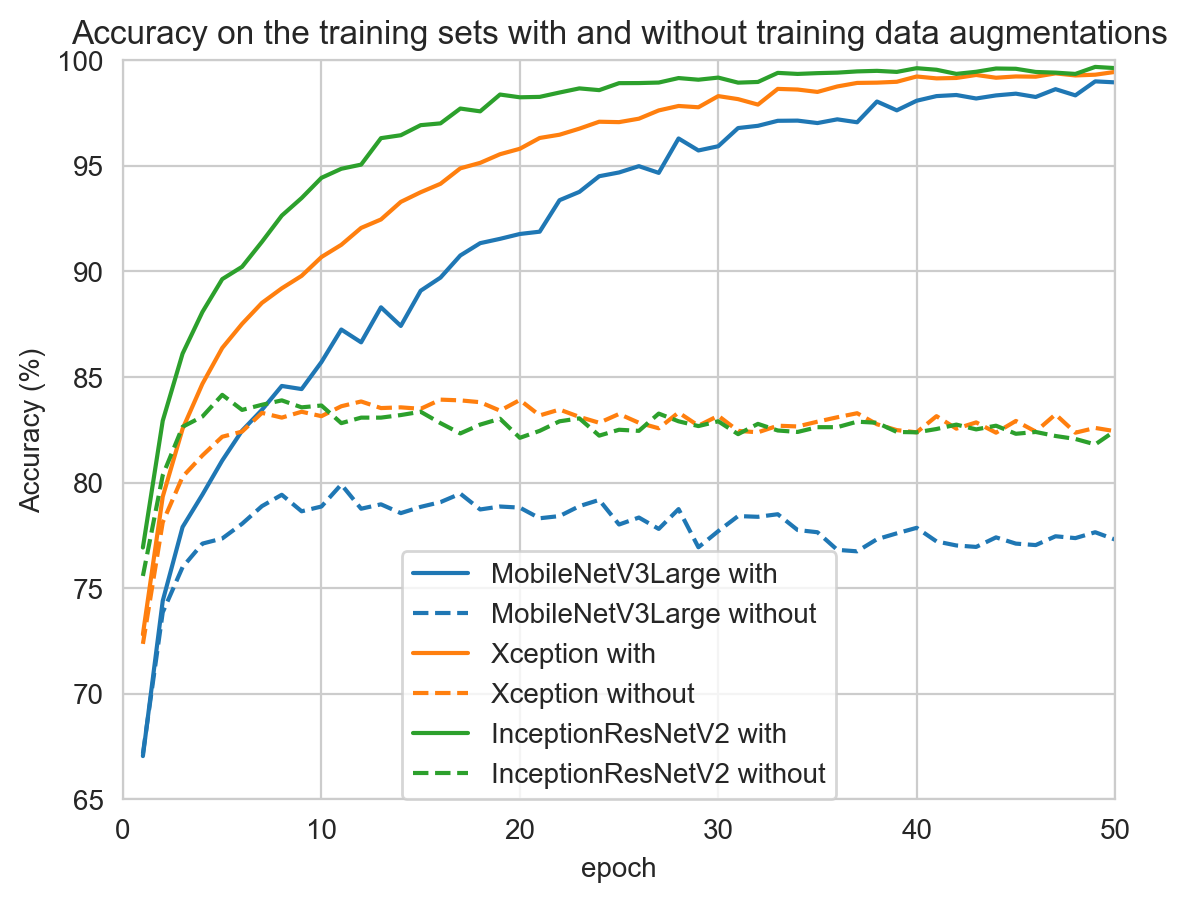

In [164]:

mpl.rcParams['figure.dpi'] = 200

x = np.arange(1, 51)
plt.plot(x, np.array(MobileNetV3LargeModelFlipData[0]) * 100, label='MobileNetV3Large Train', color='tab:blue')
# plt.plot(x, np.array(MobileNetV3LargeModelFlipData[1]) * 100, label='M3Val', color='tab:blue', linestyle='--')
plt.plot(x, np.array(MobileNetV3LargeModelFlipData[2]) * 100, label='MobileNetV3Large Test', color='tab:blue', linestyle='--')
plt.plot(x, np.array(XceptionModelFlipData[0]) * 100, color='tab:orange', label='Xception Train')
# plt.plot(x, np.array(XceptionModelFlipData[1]) * 100, color='tab:orange', label='XceptionVal', linestyle='--')
plt.plot(x, np.array(XceptionModelFlipData[2]) * 100, color='tab:orange', label='Xception Test', linestyle='--')
plt.plot(x, np.array(InceptionResNetV2ModelFlipData[0]) * 100, color='tab:green', label='InceptionResNetV2 Train')
# plt.plot(x, np.array(InceptionResNetV2ModelFlipData[1]) * 100, color='tab:green', label='InceptionResNetV2Val', linestyle='--')
plt.plot(x, np.array(InceptionResNetV2ModelFlipData[2]) * 100, color='tab:green', label='InceptionResNetV2 Test', linestyle='--')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0), borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy on the training and test set over time")
plt.xlim(0, 50)
plt.ylim(65, 100)
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

(65.0, 100.0)

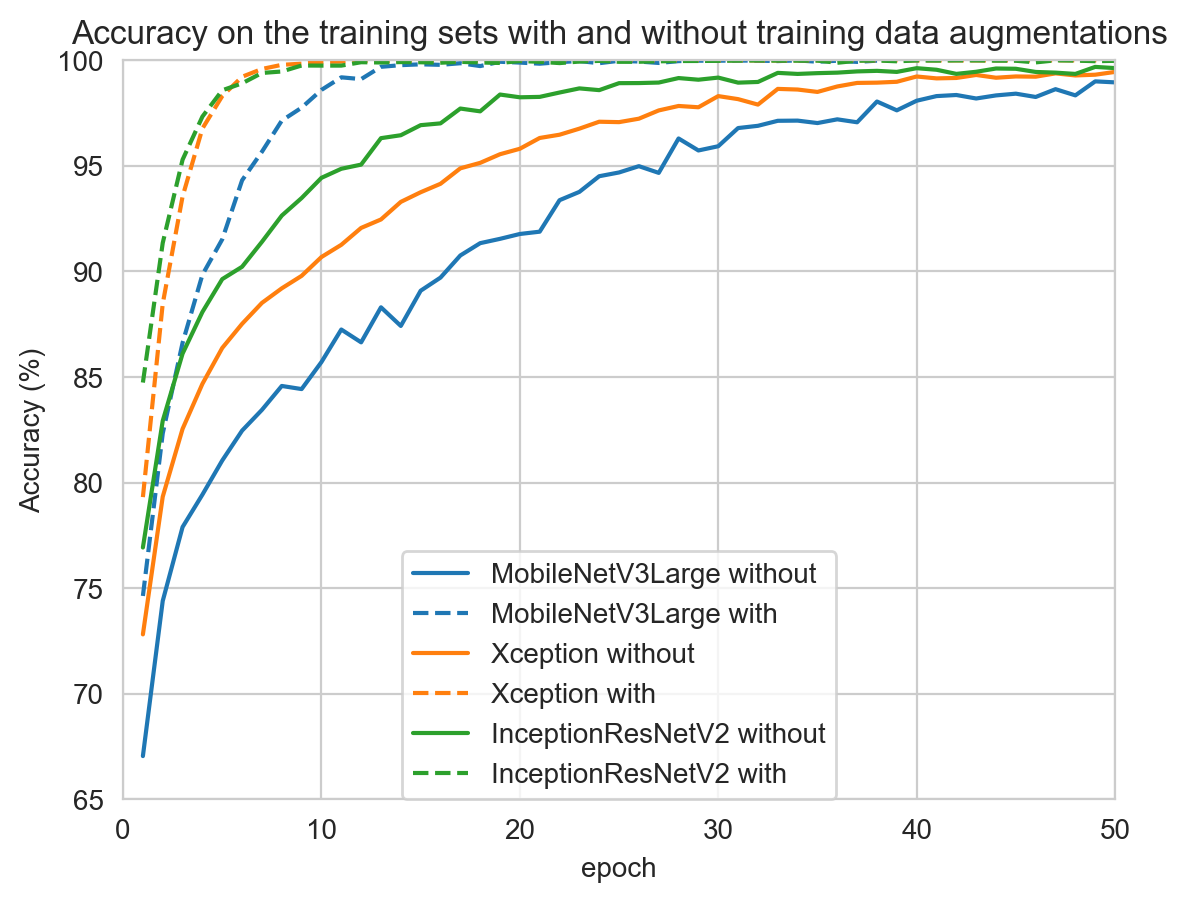

In [165]:
mpl.rcParams['figure.dpi'] = 200

x = np.arange(1, 51)
x1 = np.arange(1, len(MobileNetV3LargeModelImagenetData[0])+1)
plt.plot(x, np.array(MobileNetV3LargeModelFlipData[0]) * 100, label='MobileNetV3Large without', color='tab:blue')
plt.plot(x1, np.array(MobileNetV3LargeModelImagenetData[0]) * 100, label='MobileNetV3Large with', color='tab:blue', linestyle='--')
plt.plot(x, np.array(XceptionModelFlipData[0]) * 100, color='tab:orange', label='Xception without')
plt.plot(x, np.array(XceptionModelImagenetData[0]) * 100, color='tab:orange', label='Xception with', linestyle='--')
plt.plot(x, np.array(InceptionResNetV2ModelFlipData[0]) * 100, color='tab:green', label='InceptionResNetV2 without')
plt.plot(x, np.array(InceptionResNetV2ModelImagenetData[0]) * 100, color='tab:green', label='InceptionResNetV2 with', linestyle='--')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0), borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy on the training sets with and without training data augmentations")
plt.xlim(0, 50)
plt.ylim(65, 100)

In [196]:
np.save('MobileNetV3Large_Flip', np.array(MobileNetV3LargeModelFlipData))
np.save('Xception_Flip', np.array(XceptionModelFlipData))
np.save('InceptionResNetV2_Flip', np.array(InceptionResNetV2ModelFlipData))

# Cleanup
Here are the cleanup functions for removing old image folders

In [ ]:
import dill
dill.dump_module('notebook_env.db')
# dill.load_session('notebook_env.db')

INFO:tensorflow:Assets written to: ram://4565cda2-0422-4ec2-8457-bcd1f70aaba3/assets


INFO:tensorflow:Assets written to: ram://4565cda2-0422-4ec2-8457-bcd1f70aaba3/assets


InvalidArgumentError: Cannot convert a Tensor of dtype variant to a NumPy array.

In [ ]:
# cleanup_folder(data_resized)
# cleanup_folder(data_split)